# Testing step by step

In [1]:
# Imports
import numpy as np
import os
import time
import sys
import matplotlib.pyplot as plt
from astropy import stats
from shutil import copy

from config import CONFIG_INI
from mpfit import mpfit
from limb_darkening import limb_dark_fit
import hstmarg

In [2]:
# Data setup
localDir = CONFIG_INI.get('data_paths', 'local_path')
outDir = os.path.join(localDir, CONFIG_INI.get('data_paths', 'output_path'))
curr_model = CONFIG_INI.get('data_paths', 'current_model')
dataDir = os.path.join(localDir, os.path.join(localDir, CONFIG_INI.get('data_paths', 'data_path')), curr_model)

# READ in the txt file for the lightcurve data
x, y, err, sh = np.loadtxt(os.path.join(dataDir, 'W17_white_lightcurve_test_data.txt'), skiprows=7, unpack=True)
wavelength = np.loadtxt(os.path.join(dataDir, 'W17_wavelength_test_data.txt'), skiprows=3)

# Limb darkening parameters - user input
ld_model = CONFIG_INI.get('limb_darkening', 'ld_model')
FeH = CONFIG_INI.getfloat('limb_darkening', 'metallicity')
Teff = CONFIG_INI.getfloat('limb_darkening', 'Teff')
logg = CONFIG_INI.getfloat('limb_darkening', 'logg')

# More user input
grat = CONFIG_INI.get('technical_parameters', 'grating')
grid_selection = CONFIG_INI.get('technical_parameters', 'grid_selection')
run_name = CONFIG_INI.get('technical_parameters', 'run_name')
plotting = CONFIG_INI.get('technical_parameters', 'plotting')

# Planet parameters
rl = CONFIG_INI.getfloat('planet_parameters', 'rl')             # Rp/R* estimate
epoch = CONFIG_INI.getfloat('planet_parameters', 'epoch')       # in MJD
inclin = CONFIG_INI.getfloat('planet_parameters', 'inclin')     # this is converted into radians in the subroutine
ecc = CONFIG_INI.getfloat('planet_parameters', 'ecc')           # set to zero and not used when circular
omega = CONFIG_INI.getfloat('planet_parameters', 'omega')       # set to zero and not used when circular
Per = CONFIG_INI.getfloat('planet_parameters', 'Per')           # in days, converted to seconds in subroutine
aor = CONFIG_INI.getfloat('planet_parameters', 'aor')           # a/R* converted to system density for the subroutine

# Setting constants and preparing inputs for claculations
dtosec = CONFIG_INI.getfloat('constants', 'dtosec')     # conversion from days to seconds
big_G = CONFIG_INI.getfloat('constants', 'big_G')       # gravitational constant

persec = Per * dtosec
constant1 = (big_G * persec * persec / np.float32(4. * np.pi * np.pi)) ** (1. / 3.)
MsMpR = (aor / constant1) ** 3.

# Put data parameters in list
data_params = [rl, epoch, inclin, MsMpR, ecc, omega, Per, FeH, Teff, logg]

In [5]:
    # DEFINE LIMB DARKENING DIRECTORY, WHICH IS INSIDE THIS PACKAGE
    limbDir = os.path.join('..', 'Limb-darkening')

    # READ THE CONSTANTS
    Gr = CONFIG_INI.getfloat('constants', 'big_G')
    day_to_sec = CONFIG_INI.getfloat('constants', 'dtosec')
    HST_period = CONFIG_INI.getfloat('constants', 'HST_period')

    # We want to keep the raw data as is, so we generate helper arrays that will get changed from model to model
    img_date = x    # time array
    img_flux = y    # flux array
    img_err = err   # error array
    img_sh = sh     # shift in position array
    nexposure = len(img_date)   # Total number of exposures in the observation

    # READ IN THE PLANET STARTING PARAMETERS
    # data_params = [rl, epoch, inclin, MsMpR, ecc, omega, Per, FeH, Teff, logg]   # Description
    rl = data_params[0]                             # Rp/R* estimate
    epoch = data_params[1]                          # center of transit time in MJD
    inclin = data_params[2] * ((2 * np.pi) / 360)   # inclination, converting it to radians
    MsMpR = data_params[3]                          # density of the system
    ecc = data_params[4]                            # eccentricity
    omega = data_params[5] * ((2 * np.pi) / 360)    # orbital omega, converting it to radians
    Per = data_params[6] * day_to_sec               # period in seconds
    constant1 = ((Gr * np.square(Per)) / (4 * np.square(np.pi))) ** (1 / 3)
    aval = constant1 * (MsMpR) ** (1 / 3)   # NOT-REUSED

    flux0 = img_flux[0]   # first flux data point
    T0 = img_date[0]      # first time data point

    # SET THE STARTING PARAMETERS FOR THE SYSTEMATIC MODELS
    m_fac = 0.0  # Linear Slope
    HSTP1 = 0.0  # Correct HST orbital phase
    HSTP2 = 0.0  # Correct HST orbital phase^2
    HSTP3 = 0.0  # Correct HST orbital phase^3
    HSTP4 = 0.0  # Correct HST orbital phase^4
    xshift1 = 0.0  # X-shift in wavelength
    xshift2 = 0.0  # X-shift in wavelength^2
    xshift3 = 0.0  # X-shift in wavelength^3
    xshift4 = 0.0  # X-shift in wavelength^4

    # =======================
    # LIMB DARKENING
    # NEW: Implement a suggestion for the user to use 3D if his parameters match the options available in the 3D models

    M_H = data_params[7]    # metallicity
    Teff = data_params[8]   # effective temperature
    logg = data_params[9]   # log(g), gravitation

    uLD, c1, c2, c3, c4, cp1, cp2, cp3, cp4, aLD, bLD = limb_dark_fit(grat, wavelength, M_H, Teff,
                                                                           logg, limbDir, ld_model)
    # =======================

    # PLACE ALL THE PRIORS IN AN ARRAY
    # p0 =        [0,    1,     2,      3,     4,    5,    6,    7,  8,  9,  10, 11, 12,  13,    14,    15,    16,    17,     18,      19,      20,      21   ]
    p0 = np.array([rl, flux0, epoch, inclin, MsMpR, ecc, omega, Per, T0, c1, c2, c3, c4, m_fac, HSTP1, HSTP2, HSTP3, HSTP4, xshift1, xshift2, xshift3, xshift4])

    # Create an array with the names of the priors
    p0_names = np.array(['rl', 'flux0', 'epoch', 'inclin', 'MsMpR', 'ecc', 'omega', 'Per', 'T0', 'c1', 'c2', 'c3', 'c4',
                         'm_fac', 'HSTP1', 'HSTP2', 'HSTP3', 'HSTP4', 'xshift1', 'xshift2', 'xshift3', 'xshift4'])

    # Create a dictionary for easier use in calculations
    p0_dict = {key: val for key, val in zip(p0_names, p0)}

    # SELECT THE SYSTEMATIC GRID OF MODELS TO USE
    # 1 in the grid means the parameter is fixed, 0 means it is free
    grid = hstmarg.wfc3_systematic_model_grid_selection(grid_selection)
    nsys, nparams = grid.shape   # nsys = number of systematic models, nparams = number of parameters

    #  SET UP THE ARRAYS

    # save arrays for the first step through to get the err inflation
    w_scatter = np.zeros(nsys)
    w_params = np.zeros((nsys, nparams))   # p0 parameters, but for all the systems in one single array, so that we can acces each one of the individually during the second fit

    #################################
    #           FIRST FIT           #
    #################################

    print('\n 1ST FIT \n')
    print(
        'The first run through the data for each of the WFC3 stochastic models outlined in Table 2 of Wakeford et '
        'al. (2016) is now being preformed. Using this fit we will scale the uncertainties you input to incorporate '
        'the inherent scatter in the data for each model.')

    # Loop over all systems (= parameter combinations)
    for s in range(nsys):
        print('\n################################')
        print('SYSTEMATIC MODEL {} of {}'.format(s+1, nsys))
        systematics = grid[s, :]
        print('Systematics - fixed and free parameters:')
        print_dict = {name: fix for name, fix in zip(p0_names, systematics)}
        print(print_dict)
        print(systematics)
        print('  ')

        # Displaying img_date in terms of HST PHASE, on an interval between -0.5 and 0.5
        HSTphase = (img_date - p0_dict['T0']) / HST_period   # make phase (~time) array start at 0 by subtracting first observation time, convert in units of HST phase by dividing through one HST period
        phase2 = np.floor(HSTphase)       # identify where phase is between 0-1, between 1-2, between 2-3 and over 3
        HSTphase = HSTphase - phase2      # make phase be in interval from 0 to 1
        k = np.where(HSTphase > 0.5)[0]   # figure out where phase is bigger than 0.5
        HSTphase[k] -= 1.0                # and where it is bigger than 0.5 indeed, subtract on to get to interval [-0.5, 0.5]

        # Displaying img_date in terms of PLANET PHASE, on interval between -0.5 and 0.5
        phase = (img_date - p0_dict['epoch']) / (p0_dict['Per'] / day_to_sec)   # make center of transit time by subtracting 'epoch' from img_date, convert in units of planet phase by dividing py planet period, convert to seconds
        phase2 = np.floor(phase)          # identify integer intervals of phase (like above)
        phase = phase - phase2            # make phase be in interval from 0 to 1
        a = np.where(phase > 0.5)[0]      # figure out where phase is bigger than 0.5
        phase[a] -= 1.0                   # and where it is bigger than 0.5 indeed, subtract on to get to interval [-0.5, 0.5]

        ###############
        # MPFIT - ONE #
        ###############

        # Create two dictionaries in which each parameter in p0 gets some extra parameters assigned, which we then feed
        # info mpfit. This dictionary has the sole purpose of preparing the input data for mpfit in such a way that
        # it works.
        parinfo = []
        for i, value in enumerate(p0):
            info = {'value': 0., 'fixed': 0, 'limited': [0, 0], 'limits': [0., 0.]}
            info['value'] = value
            info['fixed'] = systematics[i]
            parinfo.append(info)
        fa = {'x': img_date, 'y': img_flux, 'err': err, 'sh': sh}

        print('\nSTART MPFIT\n')
        mpfit_result = mpfit(hstmarg.transit_circle, functkw=fa, parinfo=parinfo, quiet=1)
        print('\nTHIS ROUND OF MPFIT IS DONE\n')

        # Count free parameters by figuring out how many zeros we have in the current systematics
        nfree = sum([not p['fixed'] for p in parinfo])

        # The python mpfit does not populate the covariance matrix correctly so mpfit_result.perror is not correct
        # the mpfit_result.covar is filled sequentially by row with the values of only free parameters, this works if
        # all parameters are free but not if some are kept fixed.  The code below should work to get the proper error
        # values i.e. what should be the diagonals of the covariance.

        pcerror = mpfit_result.perror  # this is how it should be done if it was right
        pcerror = np.zeros_like(mpfit_result.perror)
        pcerror[:nfree] = np.sqrt(
            np.diag(mpfit_result.covar.flatten()[:nfree ** 2].reshape(nfree, nfree)))  # this might work...

        bestnorm = mpfit_result.fnorm  # chi squared of resulting fit

         # Redefine all of the parameters given the MPFIT output
        w_params[s, :] = mpfit_result.params
        # Populate parameters with fits results
        p0 = w_params[s, :]
        # Recreate the dictionary
        p0_dict = {key: val for key, val in zip(p0_names, p0)}

        # Populate some errors from pcerror array
        # pcerror = [rl_err, flux0_err, epoch_err, inclin_err, msmpr_err, ecc_err, omega_err, per_err, T0_err,
        #           c1_err, c2_err, c3_err, c4_err, m_err, hst1_err, hst2_err, hst3_err, hst4_err, sh1_err, sh2_err,
        #           sh3_err, sh4_err]
        rl_err = pcerror[0]

        # Recalculate a/R* (actually the constant for it) based on the new MsMpR value which may have been fit in the routine.
        constant1 = (Gr * p0_dict['Per'] * p0_dict['Per'] / (4 * np.pi * np.pi)) ** (1 / 3.)

        print('\nTRANSIT DEPTH rl in model {} of {} = {} +/- {}, centered at  {}'.format(s+1, nsys, p0_dict['rl'], rl_err, p0_dict['epoch']))

        # OUTPUTS
        # Re-Calculate each of the arrays dependent on the output parameters
        phase = (img_date - p0_dict['epoch']) / (p0_dict['Per'] / day_to_sec)
        phase2 = np.floor(phase)
        phase = phase - phase2
        a = np.where(phase > 0.5)[0]
        phase[a] = phase[a] - 1.0

        HSTphase = (img_date - p0_dict['T0']) / HST_period
        phase2 = np.floor(HSTphase)
        HSTphase = HSTphase - phase2
        k = np.where(HSTphase > 0.5)[0]
        HSTphase[k] = HSTphase[k] - 1.0

        # ...........................................
        # TRANSIT MODEL fit to the data
        # Calculate the impact parameter based on the eccentricity function
        b0 = hstmarg.impact_param(p0_dict['Per'], p0_dict['MsMpR'], phase, p0_dict['inclin'])

        mulimb01, mulimbf1 = hstmarg.occultnl(p0_dict['rl'], p0_dict['c1'], p0_dict['c2'], p0_dict['c3'], p0_dict['c4'], b0)

        systematic_model = hstmarg.sys_model(phase, HSTphase, sh, p0_dict['m_fac'], p0_dict['HSTP1'], p0_dict['HSTP2'], p0_dict['HSTP3'],
                                             p0_dict['HSTP4'], p0_dict['xshift1'], p0_dict['xshift2'],
                                             p0_dict['xshift3'], p0_dict['xshift4'])

        # Calculate final form of the model fit
        w_model = mulimb01 * p0_dict['flux0'] * systematic_model   # see Wakeford et al. 2016, Eq. 1
        # Calculate the residuals
        w_residuals = (img_flux - w_model) / p0_dict['flux0']
        # Calculate more stuff
        corrected_data = img_flux / (p0_dict['flux0'] * systematic_model)
        w_scatter[s] = np.std(w_residuals)
        print('Scatter on the residuals = {}'.format(w_scatter[s]))   # this result is rather different to IDL result

You are using the 3D limb darkening models.
Current Directories Entered:
  ../Limb-darkening
  ../Limb-darkening/3DGrid
Filename: mmu_t65g45m10v05.flx

Closest values to your inputs:
Teff:  6500
M_H:  -1.0
log(g):  4.5

Limb darkening parameters:
4param 	0.87943740	-0.75690632	0.56316819	-0.17285109
3param 	2.18170435	-3.13702297	1.39277902
Quad 	0.03258950	0.35826185
Linear 	0.33642864

 1ST FIT 

The first run through the data for each of the WFC3 stochastic models outlined in Table 2 of Wakeford et al. (2016) is now being preformed. Using this fit we will scale the uncertainties you input to incorporate the inherent scatter in the data for each model.

################################
SYSTEMATIC MODEL 1 of 50
Systematics - fixed and free parameters:
{'rl': 0, 'flux0': 0, 'epoch': 0, 'inclin': 1, 'MsMpR': 1, 'ecc': 1, 'omega': 1, 'Per': 1, 'T0': 1, 'c1': 1, 'c2': 1, 'c3': 1, 'c4': 1, 'm_fac': 1, 'HSTP1': 1, 'HSTP2': 1, 'HSTP3': 1, 'HSTP4': 1, 'xshift1': 1, 'xshift2': 1, 'xshift3': 1,

-----------------------------------
 
57957.9709255
phase[0] = -0.02907942012214937
[ 1.32581235  1.29958924  1.27338247  1.24719704  1.22103477  1.19489881
  1.16879256  1.1427197   1.1166842   1.09068925  1.06474179  0.67105757
  0.64725152  0.62373581  0.60054819  0.57772853  0.55532364  0.53338724
  0.51198097  0.49117553  0.47105103  0.45170163  0.43323147  0.41575892
  0.39941605  0.38481347  0.39992506  0.41630664  0.4338142   0.45231459
  0.47169061  0.49183768  0.51266374  0.53408819  0.55604065  0.57846072
  0.60129299  0.6244918   0.64801646  1.03955214  1.06544961  1.09139841
  1.11739343  1.14343112  1.16950495  1.19561206  1.22174878  1.24791173
  1.27409774  1.30030389  1.32652857]
Rp/R* = 0.12405509226599512
Scatter = 0.00025829076215114156
-----------------------------------
 
57957.9717892
phase[0] = -0.02931061927720413
[ 1.33560002  1.30937105  1.28315745  1.25696416  1.23079289  1.20464672
  1.17852898  1.15244321  1.12639329  1.10038227  1.07441693  0.68000765
  0

/Users/ilaginja/Documents/Git/HST_Marginalization/HST_python/mpfit.py:2183: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:



-----------------------------------
 
57957.9709255
phase[0] = -0.02907942012214937
[ 1.32581235  1.29958924  1.27338247  1.24719704  1.22103477  1.19489881
  1.16879256  1.1427197   1.1166842   1.09068925  1.06474179  0.67105757
  0.64725152  0.62373581  0.60054819  0.57772853  0.55532364  0.53338724
  0.51198097  0.49117553  0.47105103  0.45170163  0.43323147  0.41575892
  0.39941605  0.38481347  0.39992506  0.41630664  0.4338142   0.45231459
  0.47169061  0.49183768  0.51266374  0.53408819  0.55604065  0.57846072
  0.60129299  0.6244918   0.64801646  1.03955214  1.06544961  1.09139841
  1.11739343  1.14343112  1.16950495  1.19561206  1.22174878  1.24791173
  1.27409774  1.30030389  1.32652857]
Rp/R* = 0.12405509226599512
Scatter = 0.00025829076215114156
-----------------------------------
 
57957.9717892
phase[0] = -0.02931061927720413
[ 1.33560002  1.30937105  1.28315745  1.25696416  1.23079289  1.20464672
  1.17852898  1.15244321  1.12639329  1.10038227  1.07441693  0.68000765
  

TRANSIT DEPTH rl in model 2 of 50 = 0.1239933214992512 +/- 0.00019193672697876332, centered at  57957.97066676297
Scatter on the residuals = 0.00023380171174154985

################################
SYSTEMATIC MODEL 3 of 50
Systematics - fixed and free parameters:
{'rl': 0, 'flux0': 0, 'epoch': 0, 'inclin': 1, 'MsMpR': 1, 'ecc': 1, 'omega': 1, 'Per': 1, 'T0': 1, 'c1': 1, 'c2': 1, 'c3': 1, 'c4': 1, 'm_fac': 1, 'HSTP1': 1, 'HSTP2': 1, 'HSTP3': 1, 'HSTP4': 1, 'xshift1': 0, 'xshift2': 0, 'xshift3': 1, 'xshift4': 1}
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1]
  

START MPFIT

57957.9706668
phase[0] = -0.029010142677544648
[ 1.32287993  1.29665864  1.27045399  1.244271    1.21811151  1.1919787
  1.16587599  1.13980711  1.11377605  1.08778605  1.06184408  0.6683827
  0.6446076   0.62112659  0.59797798  0.57520223  0.55284692  0.53096657
  0.50962378  0.48889034  0.46884759  0.44959103  0.43122627  0.4138732
  0.39766542  0.38643504  0.40169617  0.4182105   0.43583542  0.45443932
  0.47390649

Scatter = 0.00023377460742085086
-----------------------------------
 
57957.9706659
phase[0] = -0.02900991055498503
[ 1.3228701   1.29664882  1.27044418  1.2442612   1.21810172  1.19196891
  1.16586622  1.13979735  1.11376631  1.08777632  1.06183437  0.66837375
  0.64459875  0.62111785  0.59796937  0.57519378  0.55283863  0.53095847
  0.5096159   0.4888827   0.46884022  0.44958398  0.43121957  0.41386691
  0.39765959  0.3864405   0.40170213  0.4182169   0.43584222  0.45444645
  0.47391393  0.49414152  0.51503852  0.53652552  0.55853322  0.58100217
  0.60387776  0.62711505  0.65067394  1.04245434  1.06835784  1.09431207
  1.12031197  1.14635406  1.1724318   1.19854241  1.22468224  1.25084793
  1.27703634  1.30324458  1.32947105]
Rp/R* = 0.12399247454837996
Scatter = 0.00023377460002988403
-----------------------------------
 
57957.9715295
phase[0] = -0.029241109710039792
[ 1.33265716  1.30642992  1.28021834  1.25402736  1.22785875  1.20171561
  1.17560126  1.14951932  1.12347367  1.09

Rp/R* = 0.12397674386953784
Scatter = 0.00023335856616058266
-----------------------------------
 
57957.9706918
phase[0] = -0.029016839337035583
[ 1.32316338  1.29694192  1.27073706  1.24455384  1.21839407  1.19226095
  1.1661579   1.14008863  1.11405714  1.08806666  1.06212415  0.66864112
  0.64486301  0.62137863  0.59822622  0.57544621  0.55308607  0.53120027
  0.50985131  0.48911086  0.46906016  0.44979457  0.43141955  0.41405486
  0.39783395  0.38627752  0.40152428  0.41802585  0.43563951  0.45423346
  0.47369187  0.49391149  0.51480146  0.53628227  0.5582845   0.5807486
  0.6036199   0.62685338  0.65040888  1.04216502  1.06806792  1.0940216
  1.12002103  1.14606267  1.17214003  1.19825029  1.22438982  1.25055523
  1.27674341  1.30295144  1.32917773]
Rp/R* = 0.12397674571693527
Scatter = 0.00023335856395556977
-----------------------------------
 
57957.9706918
phase[0] = -0.029016839337035583
[ 1.32316338  1.29694192  1.27073706  1.24455384  1.21839407  1.19226095
  1.1661579   1

Scatter = 0.0002327771026748164
-----------------------------------
 
57957.9706415
phase[0] = -0.029003390597458267
[ 1.32259413  1.29637302  1.27016858  1.24398584  1.21782662  1.19169411
  1.16559176  1.13952326  1.11349264  1.08750312  1.06156169  0.66812217
  0.64435011  0.6208725   0.59772772  0.57495629  0.55260584  0.530731
  0.50939445  0.48866808  0.46863335  0.44938592  0.43103151  0.41369018
  0.39749566  0.38659402  0.40186963  0.4183968   0.43603308  0.45464698
  0.47412297  0.49435805  0.51526165  0.53675448  0.55876732  0.58124082
  0.60412044  0.62736131  0.6509234   1.04272661  1.06863066  1.0945854
  1.12058576  1.14662825  1.17270636  1.1988173   1.22495742  1.25112336
  1.277312    1.30352042  1.32974706]
Rp/R* = 0.12400299447296059
Scatter = 0.0002327771028349109
-----------------------------------
 
57957.9706415
phase[0] = -0.029003390597458267
[ 1.32259413  1.29637302  1.27016858  1.24398584  1.21782662  1.19169411
  1.16559176  1.13952326  1.11349264  1.087503

[ 1.32259816  1.29637705  1.2701726   1.24398985  1.21783063  1.19169812
  1.16559576  1.13952726  1.11349663  1.0875071   1.06156567  0.66812584
  0.64435373  0.62087608  0.59773125  0.57495976  0.55260924  0.53073432
  0.50939768  0.48867121  0.46863637  0.44938881  0.43103425  0.41369275
  0.39749805  0.38659178  0.40186718  0.41839417  0.43603029  0.45464405
  0.47411991  0.49435489  0.51525839  0.53675114  0.5587639   0.58123733
  0.6041169   0.62735772  0.65091976  1.04272263  1.06862668  1.09458141
  1.12058176  1.14662425  1.17270236  1.19881328  1.2249534   1.25111934
  1.27730797  1.3035164   1.32974303]
Rp/R* = 0.12400327822476999
Scatter = 0.00023277578438008753
-----------------------------------
 
57957.9706419
phase[0] = -0.029003485755008107
[ 1.32259816  1.29637705  1.2701726   1.24398985  1.21783063  1.19169812
  1.16559576  1.13952726  1.11349663  1.0875071   1.06156567  0.66812584
  0.64435373  0.62087608  0.59773125  0.57495976  0.55260924  0.53073432
  0.50939768 

Rp/R* = 0.1239829762760083
Scatter = 0.00023098396612768397
-----------------------------------
 
57957.970548
phase[0] = -0.028978349676109127
[ 1.32153424  1.2953138   1.26911013  1.24292828  1.21677007  1.19063872
  1.16453766  1.13847061  1.11244161  1.08645389  1.06051446  0.66715624
  0.64339547  0.61993054  0.5968      0.57404461  0.55171227  0.52985791
  0.50854456  0.4878445   0.46783965  0.44862615  0.43031025  0.41301258
  0.39686741  0.38718511  0.40251422  0.41908887  0.43676711  0.45541802
  0.47492659  0.49519036  0.51611924  0.53763436  0.55966689  0.58215781
  0.60505288  0.62830747  0.65188177  1.04377233  1.06967854  1.09563521
  1.12163731  1.14768137  1.17376088  1.19987306  1.22601429  1.25218121
  1.2783707   1.30457987  1.33080715]
Rp/R* = 0.12398832222753486
Scatter = 0.00023095807387648248
-----------------------------------
 
57957.970548
phase[0] = -0.028978349676109127
[ 1.32153424  1.2953138   1.26911013  1.24292828  1.21677007  1.19063872
  1.16453766  1.

-----------------------------------
 
57957.970548
phase[0] = -0.028978349676109127
[ 1.32153424  1.2953138   1.26911013  1.24292828  1.21677007  1.19063872
  1.16453766  1.13847061  1.11244161  1.08645389  1.06051446  0.66715624
  0.64339547  0.61993054  0.5968      0.57404461  0.55171227  0.52985791
  0.50854456  0.4878445   0.46783965  0.44862615  0.43031025  0.41301258
  0.39686741  0.38718511  0.40251422  0.41908887  0.43676711  0.45541802
  0.47492659  0.49519036  0.51611924  0.53763436  0.55966689  0.58215781
  0.60505288  0.62830747  0.65188177  1.04377233  1.06967854  1.09563521
  1.12163731  1.14768137  1.17376088  1.19987306  1.22601429  1.25218121
  1.2783707   1.30457987  1.33080715]
Rp/R* = 0.12398832222753486
Scatter = 0.0002309580734734173
-----------------------------------
 
57957.9704643
phase[0] = -0.028955944270624312
[ 1.32058592  1.29436608  1.26816311  1.24198206  1.21582477  1.18969445
  1.16359455  1.13752881  1.11150126  1.08551516  1.05957753  0.66629234
  0

 
57957.9704695
phase[0] = -0.028957337046885523
[ 1.32064487  1.29442499  1.26822198  1.24204088  1.21588353  1.18975314
  1.16365317  1.13758735  1.11155971  1.08557351  1.05963577  0.66634603
  0.64259478  0.61914053  0.59602199  0.57328013  0.55096306  0.52912595
  0.50783216  0.48715429  0.46717463  0.44798973  0.42970631  0.41244544
  0.39634186  0.38768287  0.40305669  0.419671    0.43738429  0.4560661
  0.47560188  0.49588962  0.51683961  0.53837335  0.56042232  0.5829278
  0.60583577  0.62910182  0.65268632  1.04464989  1.0705579   1.09651619
  1.12251976  1.14856512  1.17464581  1.20075903  1.22690118  1.25306891
  1.27925912  1.30546891  1.33169671]
Rp/R* = 0.12399912580332251
Scatter = 0.0002184537783060513
-----------------------------------
 

THIS ROUND OF MPFIT IS DONE


TRANSIT DEPTH rl in model 7 of 50 = 0.12399912580332251 +/- 0.0001916402924181188, centered at  57957.97046950831
Scatter on the residuals = 0.0002184537783060513

################################
SYSTE

/Users/ilaginja/anaconda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in sqrt


57957.9704695
phase[0] = -0.028957337046885523
[ 1.32064487  1.29442499  1.26822198  1.24204088  1.21588353  1.18975314
  1.16365317  1.13758735  1.11155971  1.08557351  1.05963577  0.66634603
  0.64259478  0.61914053  0.59602199  0.57328013  0.55096306  0.52912595
  0.50783216  0.48715429  0.46717463  0.44798973  0.42970631  0.41244544
  0.39634186  0.38768287  0.40305669  0.419671    0.43738429  0.4560661
  0.47560188  0.49588962  0.51683961  0.53837335  0.56042232  0.5829278
  0.60583577  0.62910182  0.65268632  1.04464989  1.0705579   1.09651619
  1.12251976  1.14856512  1.17464581  1.20075903  1.22690118  1.25306891
  1.27925912  1.30546891  1.33169671]
Rp/R* = 0.12399912580332251
Scatter = 0.00021845377830601481
-----------------------------------
 
57957.9704695
phase[0] = -0.028957337046885523
[ 1.32064487  1.29442499  1.26822198  1.24204088  1.21588353  1.18975314
  1.16365317  1.13758735  1.11155971  1.08557351  1.05963577  0.66634603
  0.64259478  0.61914053  0.59602199  0.5

 
57957.9704624
phase[0] = -0.028955433068076575
[ 1.32056428  1.29434445  1.2681415   1.24196047  1.2158032   1.1896729
  1.16357303  1.13750732  1.1114798   1.08549374  1.05955616  0.66627263
  0.64252224  0.61906896  0.59595152  0.57321088  0.5508952   0.52905966
  0.50776764  0.48709179  0.46711441  0.44793212  0.42965164  0.41239412
  0.39629432  0.38772806  0.40310592  0.41972381  0.43744027  0.45612487
  0.47566311  0.49595302  0.51690491  0.53844034  0.5604908   0.58299759
  0.60590673  0.62917382  0.65275924  1.04472941  1.07063759  1.09659602
  1.12259972  1.1486452   1.17472599  1.20083931  1.22698154  1.25314935
  1.27933962  1.30554947  1.33177732]
Rp/R* = 0.12399930356132323
Scatter = 0.00021787186803308797
-----------------------------------
 
57957.9704624
phase[0] = -0.028955433068076575
[ 1.32056428  1.29434445  1.2681415   1.24196047  1.2158032   1.1896729
  1.16357303  1.13750732  1.1114798   1.08549374  1.05955616  0.66627263
  0.64252224  0.61906896  0.59595152  0

Rp/R* = 0.12400073614094376
Scatter = 0.00021786328232466622
-----------------------------------
 
57957.9713224
phase[0] = -0.0291856645744335
[ 1.33030989  1.30408405  1.27787409  1.251685    1.22551854  1.19937783
  1.17326623  1.14718737  1.12114517  1.09514276  1.069187    0.67516606
  0.65131332  0.62774525  0.6044988   0.5816129   0.55913328  0.53711242
  0.5156105   0.4946966   0.47444897  0.45495973  0.43633079  0.4186782
  0.40213168  0.38236132  0.39723976  0.41341422  0.43073859  0.44907739
  0.46831107  0.48833281  0.50904849  0.53037562  0.55224214  0.57458621
  0.59735113  0.62049014  0.64396159  1.03511755  1.06100567  1.08694604
  1.11293348  1.13896437  1.1650321   1.19113377  1.21726566  1.24342434
  1.26960662  1.29580951  1.3220314 ]
Rp/R* = 0.12400073614094376
Scatter = 0.0002742164498431612
-----------------------------------
 
57957.9704588
phase[0] = -0.028954465421326403
[ 1.32052332  1.29430352  1.2681006   1.2419196   1.21576237  1.18963212
  1.1635323   1.1

57957.9704588
phase[0] = -0.02895445871701796
[ 1.32052304  1.29430324  1.26810032  1.24191932  1.21576209  1.18963184
  1.16353202  1.13746636  1.11143891  1.08545292  1.05951541  0.66623507
  0.64248513  0.61903234  0.59591545  0.57317545  0.55086047  0.52902574
  0.50773463  0.4870598   0.4670836   0.44790264  0.42962367  0.41236786
  0.39626999  0.38775118  0.40313111  0.41975084  0.43746892  0.45615495
  0.47569445  0.49598546  0.51693833  0.53847462  0.56052584  0.58303331
  0.60594304  0.62921066  0.65279656  1.04477011  1.07067836  1.09663687
  1.12264064  1.14868618  1.17476703  1.20088039  1.22702267  1.25319051
  1.27938082  1.30559069  1.33181857]
Rp/R* = 0.12400074577964601
Scatter = 0.0002178632011888158
-----------------------------------
 
57957.9704588
phase[0] = -0.028954469735691157
[ 1.32052351  1.29430371  1.26810079  1.24191979  1.21576256  1.1896323
  1.16353248  1.13746683  1.11143937  1.08545338  1.05951587  0.6662355
  0.64248555  0.61903275  0.59591586  0.573

57957.9704588
phase[0] = -0.028954469735691157
[ 1.32052351  1.29430371  1.26810079  1.24191979  1.21576256  1.1896323
  1.16353248  1.13746683  1.11143937  1.08545338  1.05951587  0.6662355
  0.64248555  0.61903275  0.59591586  0.57317585  0.55086086  0.52902612
  0.507735    0.48706017  0.46708395  0.44790297  0.42962399  0.41236816
  0.39627027  0.38775092  0.40313083  0.41975053  0.4374686   0.45615461
  0.4756941   0.49598509  0.51693796  0.53847423  0.56052545  0.5830329
  0.60594263  0.62921024  0.65279614  1.04476965  1.0706779   1.09663641
  1.12264017  1.14868572  1.17476656  1.20087993  1.2270222   1.25319005
  1.27938035  1.30559023  1.3318181 ]
Rp/R* = 0.12400072377524193
Scatter = 0.00021786304784357318
-----------------------------------
 
57957.9704588
phase[0] = -0.028954469735691157
[ 1.32052351  1.29430371  1.26810079  1.24191979  1.21576256  1.1896323
  1.16353248  1.13746683  1.11143937  1.08545338  1.05951587  0.6662355
  0.64248555  0.61903275  0.59591586  0.5731

57957.9704624
phase[0] = -0.028955434867838692
[ 1.32056436  1.29434453  1.26814158  1.24196054  1.21580328  1.18967298
  1.16357311  1.13750739  1.11147988  1.08549382  1.05955623  0.6662727
  0.64252231  0.61906903  0.59595158  0.57321095  0.55089526  0.52905972
  0.5077677   0.48709184  0.46711447  0.44793217  0.4296517   0.41239417
  0.39629436  0.38772801  0.40310587  0.41972376  0.43744022  0.45612481
  0.47566305  0.49595296  0.51690485  0.53844027  0.56049074  0.58299752
  0.60590666  0.62917375  0.65275917  1.04472934  1.07063751  1.09659595
  1.12259964  1.14864513  1.17472592  1.20083923  1.22698147  1.25314927
  1.27933955  1.30554939  1.33177724]
Rp/R* = 0.12401081337654704
Scatter = 0.00021771268087530157
-----------------------------------
 
57957.9704624
phase[0] = -0.028955434867838692
[ 1.32056436  1.29434453  1.26814158  1.24196054  1.21580328  1.18967298
  1.16357311  1.13750739  1.11147988  1.08549382  1.05955623  0.6662727
  0.64252231  0.61906903  0.59595158  0.5

phase[0] = -0.028955647027453013
[ 1.32057333  1.2943535   1.26815055  1.2419695   1.21581223  1.18968192
  1.16358204  1.13751631  1.11148878  1.08550271  1.0595651   0.66628088
  0.64253039  0.619077    0.59595944  0.57321867  0.55090282  0.52906711
  0.50777489  0.48709881  0.46712118  0.44793859  0.42965779  0.41239989
  0.39629966  0.38772298  0.40310038  0.41971787  0.43743398  0.45611826
  0.47565623  0.49594589  0.51689757  0.53843281  0.56048311  0.58298975
  0.60589875  0.62916572  0.65275105  1.04472048  1.07062863  1.09658705
  1.12259073  1.1486362   1.17471698  1.20083029  1.22697251  1.25314031
  1.27933058  1.30554041  1.33176826]
Rp/R* = 0.12401059333954902
Scatter = 0.00021770745784508648
-----------------------------------
 
57957.9704632
phase[0] = -0.028955649249886473
[ 1.32057343  1.2943536   1.26815064  1.2419696   1.21581232  1.18968201
  1.16358213  1.1375164   1.11148887  1.0855028   1.0595652   0.66628097
  0.64253048  0.61907709  0.59595952  0.57321875  0.5

phase[0] = -0.028955605510214366
[ 1.32057158  1.29435175  1.26814879  1.24196775  1.21581047  1.18968017
  1.16358029  1.13751457  1.11148704  1.08550097  1.05956337  0.66627928
  0.64252881  0.61907544  0.5959579   0.57321716  0.55090134  0.52906567
  0.50777348  0.48709745  0.46711987  0.44793733  0.42965659  0.41239877
  0.39629862  0.38772396  0.40310146  0.41971903  0.4374352   0.45611954
  0.47565757  0.49594727  0.516899    0.53843427  0.5604846   0.58299127
  0.6059003   0.62916729  0.65275264  1.04472221  1.07063037  1.09658879
  1.12259248  1.14863795  1.17471873  1.20083204  1.22697426  1.25314207
  1.27933233  1.30554217  1.33177002]
Rp/R* = 0.1240176089970852
Scatter = 0.00021762024314387642
-----------------------------------
 
57957.970463
phase[0] = -0.028955605510214366
[ 1.32057158  1.29435175  1.26814879  1.24196775  1.21581047  1.18968017
  1.16358029  1.13751457  1.11148704  1.08550097  1.05956337  0.66627928
  0.64252881  0.61907544  0.5959579   0.57321716  0.550

Rp/R* = 0.1240176089970852
Scatter = 0.0002176202431423034
-----------------------------------
 
57957.970463
phase[0] = -0.028955605510214366
[ 1.32057158  1.29435175  1.26814879  1.24196775  1.21581047  1.18968017
  1.16358029  1.13751457  1.11148704  1.08550097  1.05956337  0.66627928
  0.64252881  0.61907544  0.5959579   0.57321716  0.55090134  0.52906567
  0.50777348  0.48709745  0.46711987  0.44793733  0.42965659  0.41239877
  0.39629862  0.38772396  0.40310146  0.41971903  0.4374352   0.45611954
  0.47565757  0.49594727  0.516899    0.53843427  0.5604846   0.58299127
  0.6059003   0.62916729  0.65275264  1.04472221  1.07063037  1.09658879
  1.12259248  1.14863795  1.17471873  1.20083204  1.22697426  1.25314207
  1.27933233  1.30554217  1.33177002]
Rp/R* = 0.1240176089970852
Scatter = 0.00021762024313931242
-----------------------------------
 
57957.9704656
phase[0] = -0.028956292109704074
[ 1.32060064  1.29438079  1.26817781  1.24199675  1.21583944  1.18970911
  1.16360919  1.1

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0]
  

START MPFIT

57957.9704656
phase[0] = -0.028956292109704074
[ 1.32060064  1.29438079  1.26817781  1.24199675  1.21583944  1.18970911
  1.16360919  1.13754343  1.11151585  1.08552974  1.05959208  0.66630575
  0.64255497  0.61910125  0.59598331  0.57324213  0.55092581  0.52908957
  0.50779675  0.48711998  0.46714158  0.44795811  0.42967631  0.41241727
  0.39631577  0.38770767  0.40308371  0.41969998  0.43741501  0.45609835
  0.47563549  0.49592441  0.51687545  0.53841011  0.5604599   0.5829661
  0.60587471  0.62914133  0.65272634  1.04469354  1.07060163  1.09656
  1.12256364  1.14860907  1.17468981  1.20080309  1.22694528  1.25311306
  1.2793033   1.30551312  1.33174095]
Rp/R* = 0.12401763443337119
Scatter = 0.00021760256598309604
-----------------------------------
 
57957.9704656
phase[0] = -0.028956292109704074
[ 1.32060064  1.29438079  1.26817781  1.24199675  1.21583944  1.18970911
  1.16360919  1.13754343  1.11151585  1.08552974  1.0

Rp/R* = 0.12401763443337119
Scatter = 0.00021760255897698634
-----------------------------------
 
57957.9713292
phase[0] = -0.02918749126281106
[ 1.33038722  1.30416133  1.27795132  1.25176217  1.22559563  1.19945484
  1.17334316  1.1472642   1.12122188  1.09521934  1.06926344  0.67523676
  0.65138323  0.62781426  0.60456682  0.58167979  0.5591989   0.5371766
  0.51567306  0.49475731  0.47450758  0.45501597  0.43638433  0.41872868
  0.40217869  0.38231953  0.39719392  0.41336479  0.43068597  0.44902196
  0.46825317  0.48827273  0.50898649  0.53031192  0.55217695  0.5745197
  0.59728345  0.62042143  0.64389195  1.03504132  1.06092928  1.0868695
  1.11285681  1.13888758  1.1649552   1.19105678  1.21718859  1.2433472
  1.2695294   1.29573225  1.32195408]
Rp/R* = 0.12401763443337119
Scatter = 0.0002740590528040479
-----------------------------------
 
57957.9704656
phase[0] = -0.028956292109704074
[ 1.32060064  1.29438079  1.26817781  1.24199675  1.21583944  1.18970911
  1.16360919  1.137

phase[0] = -0.028956292109704074
[ 1.32060064  1.29438079  1.26817781  1.24199675  1.21583944  1.18970911
  1.16360919  1.13754343  1.11151585  1.08552974  1.05959208  0.66630575
  0.64255497  0.61910125  0.59598331  0.57324213  0.55092581  0.52908957
  0.50779675  0.48711998  0.46714158  0.44795811  0.42967631  0.41241727
  0.39631577  0.38770767  0.40308371  0.41969998  0.43741501  0.45609835
  0.47563549  0.49592441  0.51687545  0.53841011  0.5604599   0.5829661
  0.60587471  0.62914133  0.65272634  1.04469354  1.07060163  1.09656
  1.12256364  1.14860907  1.17468981  1.20080309  1.22694528  1.25311306
  1.2793033   1.30551312  1.33174095]
Rp/R* = 0.12401763443337119
Scatter = 0.00021760256551005378
-----------------------------------
 
57957.9704656
phase[0] = -0.028956292109704074
[ 1.32060064  1.29438079  1.26817781  1.24199675  1.21583944  1.18970911
  1.16360919  1.13754343  1.11151585  1.08552974  1.05959208  0.66630575
  0.64255497  0.61910125  0.59598331  0.57324213  0.55092

phase[0] = -0.028955596055620147
[ 1.32057118  1.29435135  1.26814839  1.24196735  1.21581008  1.18967977
  1.16357989  1.13751417  1.11148664  1.08550057  1.05956297  0.66627892
  0.64252845  0.61907509  0.59595755  0.57321681  0.550901    0.52906534
  0.50777316  0.48709714  0.46711957  0.44793705  0.42965632  0.41239851
  0.39629839  0.38772419  0.4031017   0.41971929  0.43743548  0.45611984
  0.47565787  0.49594759  0.51689932  0.5384346   0.56048494  0.58299161
  0.60590065  0.62916765  0.652753    1.04472261  1.07063076  1.09658919
  1.12259287  1.14863835  1.17471913  1.20083244  1.22697466  1.25314246
  1.27933273  1.30554257  1.33177042]
Rp/R* = 0.12401718186094884
Scatter = 0.00021760847332672555
-----------------------------------
 
wa = [ -6.41211300e-07   8.67923489e-07   1.06365312e-07   2.59956731e-06
   3.88081860e-05  -1.42032946e-04   7.42702799e-05   6.70924619e-02] [1 2 0 3 4 5 6 7]
wa = [ -5.14799650e-07   7.92089423e-07   9.78297208e-08   2.27088656e-06
   3.34563

Rp/R* = 0.12401763443337119
Scatter = 0.00021760256598309604
-----------------------------------
 

THIS ROUND OF MPFIT IS DONE


TRANSIT DEPTH rl in model 19 of 50 = 0.12401763443337119 +/- 0.00019731717724467114, centered at  57957.970465604965
Scatter on the residuals = 0.00021760256598309604

################################
SYSTEMATIC MODEL 20 of 50
Systematics - fixed and free parameters:
{'rl': 0, 'flux0': 0, 'epoch': 0, 'inclin': 1, 'MsMpR': 1, 'ecc': 1, 'omega': 1, 'Per': 1, 'T0': 1, 'c1': 1, 'c2': 1, 'c3': 1, 'c4': 1, 'm_fac': 1, 'HSTP1': 0, 'HSTP2': 0, 'HSTP3': 0, 'HSTP4': 1, 'xshift1': 0, 'xshift2': 0, 'xshift3': 0, 'xshift4': 0}
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0]
  

START MPFIT

57957.9704656
phase[0] = -0.028956292109704074
[ 1.32060064  1.29438079  1.26817781  1.24199675  1.21583944  1.18970911
  1.16360919  1.13754343  1.11151585  1.08552974  1.05959208  0.66630575
  0.64255497  0.61910125  0.59598331  0.57324213  0.55092581  0.52908957
  0.50779675  0.48711

-----------------------------------
 
57957.9704656
phase[0] = -0.028956292109704074
[ 1.32060064  1.29438079  1.26817781  1.24199675  1.21583944  1.18970911
  1.16360919  1.13754343  1.11151585  1.08552974  1.05959208  0.66630575
  0.64255497  0.61910125  0.59598331  0.57324213  0.55092581  0.52908957
  0.50779675  0.48711998  0.46714158  0.44795811  0.42967631  0.41241727
  0.39631577  0.38770767  0.40308371  0.41969998  0.43741501  0.45609835
  0.47563549  0.49592441  0.51687545  0.53841011  0.5604599   0.5829661
  0.60587471  0.62914133  0.65272634  1.04469354  1.07060163  1.09656
  1.12256364  1.14860907  1.17468981  1.20080309  1.22694528  1.25311306
  1.2793033   1.30551312  1.33174095]
Rp/R* = 0.12401763443337119
Scatter = 0.00021760256598309604
-----------------------------------
 

THIS ROUND OF MPFIT IS DONE


TRANSIT DEPTH rl in model 20 of 50 = 0.12401763443337119 +/- 0.00019731717724467114, centered at  57957.970465604965
Scatter on the residuals = 0.00021760256598309604


 
57957.9704563
phase[0] = -0.028953809452852197
[ 1.32049556  1.29427578  1.26807288  1.2418919   1.2157347   1.18960448
  1.16350469  1.13743907  1.11141166  1.08542572  1.05948826  0.66621005
  0.64246039  0.61900794  0.59589142  0.57315184  0.55083733  0.52900313
  0.50771263  0.48703849  0.46706307  0.44788299  0.42960504  0.41235036
  0.39625378  0.38776659  0.4031479   0.41976885  0.43748801  0.45617499
  0.47571533  0.49600708  0.51696061  0.53849747  0.5605492   0.58305711
  0.60596724  0.62923521  0.65282142  1.04479723  1.07070554  1.0966641
  1.1226679   1.14871349  1.17479437  1.20090777  1.22705007  1.25321794
  1.27940827  1.30561816  1.33184606]
Rp/R* = 0.12400642810273414
Scatter = 0.00021686571492733525
-----------------------------------
 
57957.9704563
phase[0] = -0.028953809452852197
[ 1.32049556  1.29427578  1.26807288  1.2418919   1.2157347   1.18960448
  1.16350469  1.13743907  1.11141166  1.08542572  1.05948826  0.66621005
  0.64246039  0.61900794  0.59589142  

Systematics - fixed and free parameters:
{'rl': 0, 'flux0': 0, 'epoch': 0, 'inclin': 1, 'MsMpR': 1, 'ecc': 1, 'omega': 1, 'Per': 1, 'T0': 1, 'c1': 1, 'c2': 1, 'c3': 1, 'c4': 1, 'm_fac': 1, 'HSTP1': 0, 'HSTP2': 0, 'HSTP3': 0, 'HSTP4': 0, 'xshift1': 0, 'xshift2': 1, 'xshift3': 1, 'xshift4': 1}
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1]
  

START MPFIT

57957.9704568
phase[0] = -0.028953945153743388
[ 1.3205013   1.29428152  1.26807861  1.24189763  1.21574042  1.1896102
  1.1635104   1.13744478  1.11141736  1.08543141  1.05949394  0.66621528
  0.64246556  0.61901304  0.59589644  0.57315677  0.55084217  0.52900786
  0.50771723  0.48704295  0.46706736  0.4478871   0.42960893  0.41235402
  0.39625717  0.38776337  0.40314439  0.41976509  0.43748402  0.4561708
  0.47571097  0.49600256  0.51695595  0.53849269  0.56054432  0.58305213
  0.60596218  0.62923008  0.65281623  1.04479156  1.07069986  1.09665841
  1.12266221  1.14870778  1.17478865  1.20090205  1.22704435  1.25321221
  1.27940253  1

57957.9704573
phase[0] = -0.028954062157755756
[ 1.32050626  1.29428647  1.26808356  1.24190257  1.21574536  1.18961513
  1.16351533  1.13744969  1.11142227  1.08543631  1.05949883  0.66621979
  0.64247002  0.61901743  0.59590077  0.57316103  0.55084634  0.52901193
  0.50772119  0.48704679  0.46707106  0.44789064  0.42961229  0.41235717
  0.39626009  0.3877606   0.40314137  0.41976184  0.43748058  0.45616719
  0.47570721  0.49599867  0.51695194  0.53848857  0.56054011  0.58304784
  0.60595782  0.62922566  0.65281175  1.04478667  1.07069496  1.0966535
  1.12265729  1.14870286  1.17478373  1.20089711  1.22703941  1.25320727
  1.27939759  1.30560747  1.33183536]
Rp/R* = 0.12400694676881016
Scatter = 0.0002168621148481917
-----------------------------------
 
57957.9704573
phase[0] = -0.028954062157755756
[ 1.32050626  1.29428647  1.26808356  1.24190257  1.21574536  1.18961513
  1.16351533  1.13744969  1.11142227  1.08543631  1.05949883  0.66621979
  0.64247002  0.61901743  0.59590077  0.5

phase[0] = -0.02895409455152509
[ 1.32050763  1.29428784  1.26808493  1.24190394  1.21574673  1.18961649
  1.16351669  1.13745106  1.11142363  1.08543767  1.05950019  0.66622104
  0.64247125  0.61901865  0.59590197  0.57316221  0.55084749  0.52901306
  0.50772229  0.48704785  0.46707209  0.44789162  0.42961322  0.41235804
  0.3962609   0.38775983  0.40314053  0.41976094  0.43747963  0.45616619
  0.47570616  0.49599759  0.51695083  0.53848743  0.56053894  0.58304666
  0.60595661  0.62922443  0.65281051  1.04478532  1.0706936   1.09665214
  1.12265593  1.1487015   1.17478236  1.20089575  1.22703804  1.2532059
  1.27939622  1.3056061   1.33183399]
Rp/R* = 0.12400691609561555
Scatter = 0.0002168616957167465
-----------------------------------
 
57957.9704574
phase[0] = -0.02895409455152509
[ 1.32050763  1.29428784  1.26808493  1.24190394  1.21574673  1.18961649
  1.16351669  1.13745106  1.11142363  1.08543767  1.05950019  0.66622104
  0.64247125  0.61901865  0.59590197  0.57316221  0.55084

Scatter = 0.00027324984073869805
-----------------------------------
 
57957.9704493
phase[0] = -0.028951922503610117
[ 1.32041569  1.29419596  1.26799312  1.24181221  1.21565509  1.18952495
  1.16342527  1.13735976  1.11133247  1.08534667  1.05940936  0.66613731
  0.64238851  0.61893702  0.59582158  0.57308322  0.55077009  0.52893744
  0.5076487   0.48697656  0.46700341  0.44782591  0.42955088  0.41229952
  0.39620668  0.3878114   0.40319671  0.41982121  0.43754351  0.45623325
  0.47577603  0.49606993  0.51702534  0.53856387  0.56061707  0.58312628
  0.60603757  0.62930657  0.6528937   1.04487604  1.07078451  1.09674321
  1.12274715  1.14879285  1.17487384  1.20098733  1.22712972  1.25329766
  1.27948805  1.305698    1.33192594]
Rp/R* = 0.12399137987249813
Scatter = 0.0002167168421367347
-----------------------------------
 
57957.9704493
phase[0] = -0.028951922503610117
[ 1.32041569  1.29419596  1.26799312  1.24181221  1.21565509  1.18952495
  1.16342527  1.13735976  1.11133247  1.08

-----------------------------------
 
57957.9704501
phase[0] = -0.028952148506199538
[ 1.32042526  1.29420552  1.26800268  1.24182176  1.21566462  1.18953448
  1.16343478  1.13736926  1.11134195  1.08535613  1.05941881  0.66614602
  0.64239712  0.61894551  0.59582995  0.57309144  0.55077814  0.52894531
  0.50765636  0.48698398  0.46701056  0.44783274  0.42955736  0.41230561
  0.39621232  0.38780603  0.40319086  0.41981494  0.43753686  0.45622627
  0.47576876  0.4960624   0.51701759  0.53855591  0.56060894  0.583118
  0.60602915  0.62929802  0.65288504  1.0448666   1.07077505  1.09673374
  1.12273766  1.14878335  1.17486432  1.2009778   1.22712018  1.25328811
  1.2794785   1.30568844  1.33191637]
Rp/R* = 0.12399199417340431
Scatter = 0.00021671340495413018
-----------------------------------
 
57957.9704501
phase[0] = -0.028952148506199538
[ 1.32042526  1.29420552  1.26800268  1.24182176  1.21566462  1.18953448
  1.16343478  1.13736926  1.11134195  1.08535613  1.05941881  0.66614602
  0

-----------------------------------
 
57957.9704501
phase[0] = -0.028952148506199538
[ 1.32042526  1.29420552  1.26800268  1.24182176  1.21566462  1.18953448
  1.16343478  1.13736926  1.11134195  1.08535613  1.05941881  0.66614602
  0.64239712  0.61894551  0.59582995  0.57309144  0.55077814  0.52894531
  0.50765636  0.48698398  0.46701056  0.44783274  0.42955736  0.41230561
  0.39621232  0.38780603  0.40319086  0.41981494  0.43753686  0.45622627
  0.47576876  0.4960624   0.51701759  0.53855591  0.56060894  0.583118
  0.60602915  0.62929802  0.65288504  1.0448666   1.07077505  1.09673374
  1.12273766  1.14878335  1.17486432  1.2009778   1.22712018  1.25328811
  1.2794785   1.30568844  1.33191637]
Rp/R* = 0.12399199417340431
Scatter = 0.00021671340495670353
-----------------------------------
 
57957.9704497
phase[0] = -0.028952026211977455
[ 1.32042008  1.29420035  1.26799751  1.24181659  1.21565946  1.18952932
  1.16342963  1.13736412  1.11133682  1.08535101  1.0594137   0.66614131
  0

 
57957.9713144
phase[0] = -0.02918350494176014
[ 1.33021846  1.30399267  1.27778278  1.25159376  1.22542739  1.19928677
  1.17317529  1.14709655  1.12105448  1.09505222  1.06909663  0.67508247
  0.65123067  0.62766365  0.60441839  0.58153382  0.55905571  0.53703654
  0.51553655  0.49462483  0.47437967  0.45489325  0.43626751  0.41861853
  0.40207611  0.38241074  0.39729397  0.41347268  0.43080081  0.44914293
  0.46837954  0.48840386  0.5091218   0.53045093  0.55231921  0.57466484
  0.59743115  0.62057139  0.64404393  1.03520767  1.06109599  1.08703653
  1.11302413  1.13905515  1.16512301  1.19122479  1.21735678  1.24351555
  1.2696979   1.29590087  1.32212281]
Rp/R* = 0.12399328889910449
Scatter = 0.0002732807179064384
-----------------------------------
 
57957.9704507
phase[0] = -0.028952305788653154
[ 1.32043192  1.29421218  1.26800932  1.2418284   1.21567126  1.18954111
  1.1634414   1.13737587  1.11134856  1.08536272  1.05942539  0.66615208
  0.64240311  0.61895142  0.59583577  0

57957.9704506
phase[0] = -0.028952286125668247
[ 1.32043108  1.29421134  1.26800849  1.24182757  1.21567043  1.18954028
  1.16344057  1.13737504  1.11134773  1.0853619   1.05942457  0.66615132
  0.64240236  0.61895068  0.59583504  0.57309644  0.55078304  0.5289501
  0.50766102  0.4869885   0.46701491  0.44783691  0.42956131  0.41230931
  0.39621576  0.38780276  0.4031873   0.41981112  0.43753281  0.45622203
  0.47576433  0.49605781  0.51701286  0.53855107  0.56060399  0.58311295
  0.60602402  0.62929282  0.65287977  1.04486085  1.07076929  1.09672797
  1.12273188  1.14877756  1.17485852  1.200972    1.22711437  1.2532823
  1.27947268  1.30568261  1.33191055]
Rp/R* = 0.1239929929252573
Scatter = 0.0002166908685706533
-----------------------------------
 
57957.9704506
phase[0] = -0.028952286125668247
[ 1.32043108  1.29421134  1.26800849  1.24182757  1.21567043  1.18954028
  1.16344057  1.13737504  1.11134773  1.0853619   1.05942457  0.66615132
  0.64240236  0.61895068  0.59583504  0.573

 
57957.9704506
phase[0] = -0.02895226644515314
[ 1.32043025  1.29421051  1.26800766  1.24182674  1.2156696   1.18953945
  1.16343974  1.13737421  1.1113469   1.08536108  1.05942374  0.66615057
  0.64240161  0.61894994  0.59583431  0.57309572  0.55078234  0.52894942
  0.50766035  0.48698785  0.46701428  0.44783631  0.42956075  0.41230878
  0.39621527  0.38780323  0.40318781  0.41981166  0.43753339  0.45622263
  0.47576497  0.49605847  0.51701354  0.53855176  0.5606047   0.58311367
  0.60602475  0.62929356  0.65288052  1.04486167  1.07077011  1.09672879
  1.12273271  1.14877839  1.17485935  1.20097283  1.2271152   1.25328313
  1.27947351  1.30568345  1.33191138]
Rp/R* = 0.12399276213474639
Scatter = 0.00021669078087324808
-----------------------------------
 
57957.9704506
phase[0] = -0.02895226644515314
[ 1.32043025  1.29421051  1.26800766  1.24182674  1.2156696   1.18953945
  1.16343974  1.13737421  1.1113469   1.08536108  1.05942374  0.66615057
  0.64240161  0.61894994  0.59583431  0

Scatter = 0.00021669078087324808
-----------------------------------
 
57957.9704506
phase[0] = -0.02895226644515314
[ 1.32043025  1.29421051  1.26800766  1.24182674  1.2156696   1.18953945
  1.16343974  1.13737421  1.1113469   1.08536108  1.05942374  0.66615057
  0.64240161  0.61894994  0.59583431  0.57309572  0.55078234  0.52894942
  0.50766035  0.48698785  0.46701428  0.44783631  0.42956075  0.41230878
  0.39621527  0.38780323  0.40318781  0.41981166  0.43753339  0.45622263
  0.47576497  0.49605847  0.51701354  0.53855176  0.5606047   0.58311367
  0.60602475  0.62929356  0.65288052  1.04486167  1.07077011  1.09672879
  1.12273271  1.14877839  1.17485935  1.20097283  1.2271152   1.25328313
  1.27947351  1.30568345  1.33191138]
Rp/R* = 0.1239927602871103
Scatter = 0.00021669077372093193
-----------------------------------
 
57957.9713142
phase[0] = -0.029183465598260128
[ 1.3302168   1.30399101  1.27778112  1.2515921   1.22542573  1.19928512
  1.17317363  1.14709489  1.12105283  1.095

SYSTEMATIC MODEL 27 of 50
Systematics - fixed and free parameters:
{'rl': 0, 'flux0': 0, 'epoch': 0, 'inclin': 1, 'MsMpR': 1, 'ecc': 1, 'omega': 1, 'Per': 1, 'T0': 1, 'c1': 1, 'c2': 1, 'c3': 1, 'c4': 1, 'm_fac': 0, 'HSTP1': 1, 'HSTP2': 1, 'HSTP3': 1, 'HSTP4': 1, 'xshift1': 0, 'xshift2': 1, 'xshift3': 1, 'xshift4': 1}
[0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1]
  

START MPFIT

57957.9701274
phase[0] = -0.02886574324216684
[ 1.31676831  1.29055093  1.26435081  1.23817302  1.21201945  1.18589334
  1.15979818  1.13373773  1.1077161   1.08173659  1.05580628  0.66281792
  0.63910859  0.61570138  0.59263574  0.56995348  0.54770369  0.52594269
  0.50473512  0.48415507  0.46428649  0.44522775  0.42708751  0.40998889
  0.3940686   0.38987125  0.40543787  0.42222315  0.44008751  0.45890247
  0.47855552  0.49894651  0.51998747  0.54160146  0.56372133  0.58628954
  0.60925315  0.63256864  0.65619717  1.04847595  1.07439172  1.10035701
  1.12636686  1.15241787  1.1785036   1.20462132  1.23076746 

phase[0] = -0.028854633805665775
[ 1.31629815  1.29008107  1.26388131  1.23770393  1.21155082  1.18542523
  1.15933065  1.13327087  1.10724997  1.08127128  1.05534188  0.66239039
  0.6386862   0.61528475  0.59222559  0.56955062  0.54730908  0.52555741
  0.5043604   0.48379235  0.46393738  0.4448941   0.42677141  0.40969267
  0.39379483  0.39013873  0.40572851  0.42253431  0.4404168   0.45924775
  0.47891487  0.49931825  0.52037013  0.54199375  0.56412213  0.58669788
  0.60966817  0.6329896   0.65662341  1.04894009  1.0748568   1.10082293
  1.12683354  1.15288523  1.17897157  1.20508983  1.23123644  1.25740811
  1.28360176  1.30981452  1.33604488]
Rp/R* = 0.1240167154311478
Scatter = 0.00017347657662857206
-----------------------------------
 
57957.9700859
phase[0] = -0.028854633805665775
[ 1.31629815  1.29008107  1.26388131  1.23770393  1.21155082  1.18542523
  1.15933065  1.13327087  1.10724997  1.08127128  1.05534188  0.66239039
  0.6386862   0.61528475  0.59222559  0.56955062  0.54

phase[0] = -0.028854244420130515
[ 1.31628167  1.2900646   1.26386485  1.23768749  1.2115344   1.18540882
  1.15931427  1.13325451  1.10723364  1.08125497  1.0553256   0.66237541
  0.63867139  0.61527015  0.59221121  0.56953651  0.54729525  0.52554391
  0.50434727  0.48377964  0.46392515  0.44488241  0.42676034  0.4096823
  0.39378525  0.39014811  0.4057387   0.42254523  0.44042835  0.45925985
  0.47892747  0.49933128  0.52038354  0.5420075   0.56413618  0.5867122
  0.60968272  0.63300436  0.65663835  1.04895636  1.0748731   1.10083926
  1.1268499   1.15290161  1.17898797  1.20510625  1.23125288  1.25742456
  1.28361822  1.309831    1.33606136]
Rp/R* = 0.12401634087159517
Scatter = 0.00017341026656465534
-----------------------------------
 
57957.970948
phase[0] = -0.029085443571289726
[ 1.32606732  1.29984405  1.2736371   1.24745146  1.22128895  1.19515272
  1.16904616  1.14297296  1.11693708  1.09094171  1.06499377  0.67129029
  0.64748158  0.62396287  0.60077188  0.57794842  0.5555

-----------------------------------
 
57957.9700844
phase[0] = -0.028854244420130515
[ 1.31628167  1.2900646   1.26386485  1.23768749  1.2115344   1.18540882
  1.15931427  1.13325451  1.10723364  1.08125497  1.0553256   0.66237541
  0.63867139  0.61527015  0.59221121  0.56953651  0.54729525  0.52554391
  0.50434727  0.48377964  0.46392515  0.44488241  0.42676034  0.4096823
  0.39378525  0.39014811  0.4057387   0.42254523  0.44042835  0.45925985
  0.47892747  0.49933128  0.52038354  0.5420075   0.56413618  0.5867122
  0.60968272  0.63300436  0.65663835  1.04895636  1.0748731   1.10083926
  1.1268499   1.15290161  1.17898797  1.20510625  1.23125288  1.25742456
  1.28361822  1.309831    1.33606136]
Rp/R* = 0.12401634087159517
Scatter = 0.0001734102735024153
-----------------------------------
 
57957.9700844
phase[0] = -0.028854244420130515
[ 1.31628167  1.2900646   1.26386485  1.23768749  1.2115344   1.18540882
  1.15931427  1.13325451  1.10723364  1.08125497  1.0553256   0.66237541
  0.

-----------------------------------
 
57957.9709289
phase[0] = -0.029080309290313466
[ 1.32584999  1.29962685  1.27342006  1.2472346   1.22107229  1.19493629
  1.16882999  1.14275708  1.11672153  1.09072652  1.06477899  0.67109192
  0.64728548  0.62376933  0.60058121  0.57776098  0.55535546  0.53341835
  0.51201127  0.49120492  0.47107937  0.45172879  0.43325729  0.41578321
  0.39943862  0.38479277  0.39990243  0.41628229  0.43378833  0.45228739
  0.47166223  0.49180826  0.51263341  0.53405706  0.5560088   0.57842824
  0.60125996  0.62445827  0.64798248  1.03951502  1.06541242  1.09136114
  1.1173561   1.14339374  1.16946751  1.19557457  1.22171126  1.24787417
  1.27406015  1.30026628  1.32649094]
Rp/R* = 0.12402378822166936
Scatter = 0.0002398527811104833
-----------------------------------
 
57957.9700652
phase[0] = -0.028849110139154255
[ 1.31606438  1.28984746  1.26364787  1.23747069  1.21131782  1.18519249
  1.1590982   1.13303875  1.10701822  1.08103993  1.05511098  0.66217786
  

-----------------------------------
 
57957.9700652
phase[0] = -0.028849110139154255
[ 1.31606438  1.28984746  1.26364787  1.23747069  1.21131782  1.18519249
  1.1590982   1.13303875  1.10701822  1.08103993  1.05511098  0.66217786
  0.63847622  0.61507764  0.5920217   0.56935038  0.54711293  0.52536591
  0.50417417  0.48361208  0.4637639   0.44472832  0.42661437  0.40954553
  0.39365888  0.39027188  0.40587316  0.42268915  0.44058064  0.45941952
  0.47909362  0.49950316  0.52056046  0.54218886  0.56432147  0.58690096
  0.60987457  0.63319894  0.65683538  1.04917087  1.07508804  1.10105459
  1.12706558  1.1531176   1.17920424  1.20532277  1.23146962  1.2576415
  1.28383533  1.31004826  1.33627875]
Rp/R* = 0.12402378822166936
Scatter = 0.0001730155137110112
-----------------------------------
 
57957.9700652
phase[0] = -0.028849110139154255
[ 1.31606438  1.28984746  1.26364787  1.23747069  1.21131782  1.18519249
  1.1590982   1.13303875  1.10701822  1.08103993  1.05511098  0.66217786
  0

phase[0] = -0.028853677602208028
[ 1.31625768  1.29004063  1.26384089  1.23766355  1.21151049  1.18538494
  1.15929041  1.13323069  1.10720985  1.08123123  1.0553019   0.6623536
  0.63864984  0.61524889  0.59219029  0.56951596  0.54727512  0.52552425
  0.50432816  0.48376114  0.46390734  0.4448654   0.42674422  0.40966719
  0.39377129  0.39016177  0.40575354  0.42256111  0.44044516  0.45927748
  0.47894581  0.49935025  0.52040307  0.54202752  0.56415664  0.58673303
  0.6097039   0.63302584  0.65666011  1.04898004  1.07489683  1.10086303
  1.12687371  1.15292545  1.17901184  1.20513015  1.23127681  1.25744851
  1.28364219  1.30985498  1.33608536]
Rp/R* = 0.12402578548542581
Scatter = 0.00017284458830626
-----------------------------------
 
57957.9700823
phase[0] = -0.028853677602208028
[ 1.31625768  1.29004063  1.26384089  1.23766355  1.21151049  1.18538494
  1.15929041  1.13323069  1.10720985  1.08123123  1.0553019   0.6623536
  0.63864984  0.61524889  0.59219029  0.56951596  0.547275

phase[0] = -0.029086867781057735
[ 1.32612761  1.2999043   1.27369731  1.24751162  1.22134905  1.19521275
  1.16910613  1.14303284  1.11699687  1.0910014   1.06505335  0.67134532
  0.64753598  0.62401656  0.60082478  0.57800042  0.55559024  0.53364787
  0.51223483  0.49142171  0.47128848  0.45192919  0.43344778  0.41596248
  0.3996052   0.3846402   0.3997356   0.4161028   0.43359764  0.45208682
  0.47145297  0.49159133  0.51240974  0.53382743  0.55577393  0.57818872
  0.60101632  0.62421098  0.64773193  1.03924122  1.06513805  1.09108626
  1.11708075  1.14311797  1.16919137  1.1952981   1.22143449  1.24759714
  1.2737829   1.29998882  1.32621331]
Rp/R* = 0.12402345143112278
Scatter = 0.0002394325212223865
-----------------------------------
 
57957.9700897
phase[0] = -0.028855668629898523
[ 1.31634194  1.29012484  1.26392504  1.23774762  1.21159447  1.18546883
  1.1593742   1.13331436  1.10729339  1.08131462  1.05538513  0.66243021
  0.63872554  0.61532355  0.59226379  0.56958814  0.54

Rp/R* = 0.12402345143112278
Scatter = 0.00017236074957390488
-----------------------------------
 
57957.9700897
phase[0] = -0.028855668629898523
[ 1.31634194  1.29012484  1.26392504  1.23774762  1.21159447  1.18546883
  1.1593742   1.13331436  1.10729339  1.08131462  1.05538513  0.66243021
  0.63872554  0.61532355  0.59226379  0.56958814  0.54734583  0.52559329
  0.5043953   0.48382612  0.46396989  0.44492517  0.42680084  0.40972025
  0.39382032  0.39011379  0.40570142  0.42250532  0.44038612  0.45921557
  0.47888138  0.49928361  0.52033448  0.5419572   0.56408479  0.58665984
  0.60962951  0.63295039  0.65658371  1.04889686  1.07481348  1.10077953
  1.12679007  1.15284169  1.17892798  1.20504619  1.23119276  1.25736438
  1.283558    1.30977074  1.33600106]
Rp/R* = 0.12402345143112278
Scatter = 0.00017236074953249725
-----------------------------------
 
57957.9700894
phase[0] = -0.02885557784125159
[ 1.3163381   1.290121    1.2639212   1.23774379  1.21159064  1.18546501
  1.15937038  

Scatter on the residuals = 0.00017233887441454637

################################
SYSTEMATIC MODEL 34 of 50
Systematics - fixed and free parameters:
{'rl': 0, 'flux0': 0, 'epoch': 0, 'inclin': 1, 'MsMpR': 1, 'ecc': 1, 'omega': 1, 'Per': 1, 'T0': 1, 'c1': 1, 'c2': 1, 'c3': 1, 'c4': 1, 'm_fac': 0, 'HSTP1': 0, 'HSTP2': 1, 'HSTP3': 1, 'HSTP4': 1, 'xshift1': 0, 'xshift2': 0, 'xshift3': 0, 'xshift4': 1}
[0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1]
  

START MPFIT

57957.9700894
phase[0] = -0.028855586208976547
[ 1.31633845  1.29012135  1.26392155  1.23774414  1.211591    1.18546536
  1.15937073  1.13331089  1.10728993  1.08131117  1.05538169  0.66242704
  0.6387224   0.61532046  0.59226074  0.56958515  0.5473429   0.52559043
  0.50439252  0.48382343  0.4639673   0.44492269  0.4267985   0.40971805
  0.39381829  0.39011578  0.40570358  0.42250763  0.44038856  0.45921814
  0.47888405  0.49928637  0.52033732  0.54196011  0.56408777  0.58666287
  0.60963259  0.63295351  0.65658687  1.0489003  

Scatter = 0.00017233463069992358
-----------------------------------
 
57957.9700902
phase[0] = -0.02885579364908497
[ 1.31634723  1.29013012  1.26393032  1.2377529   1.21159975  1.1854741
  1.15937946  1.13331961  1.10729864  1.08131986  1.05539036  0.66243502
  0.63873029  0.61532824  0.5922684   0.56959268  0.54735027  0.52559762
  0.50439952  0.4838302   0.46397382  0.44492892  0.4268044   0.40972358
  0.39382339  0.39011078  0.40569815  0.42250181  0.44038241  0.45921169
  0.47887734  0.49927943  0.52033017  0.54195279  0.56408028  0.58665525
  0.60962484  0.63294565  0.65657891  1.04889163  1.07480824  1.10077428
  1.12678482  1.15283643  1.17892271  1.20504091  1.23118748  1.2573591
  1.28355271  1.30976545  1.33599577]
Rp/R* = 0.12402280773007789
Scatter = 0.00017233462359655442
-----------------------------------
 
57957.9709538
phase[0] = -0.029086992800244182
[ 1.3261329   1.29990959  1.27370259  1.2475169   1.22135433  1.19521802
  1.16911139  1.1430381   1.11700212  1.0910

-----------------------------------
 
57957.9709538
phase[0] = -0.029086992800244182
[ 1.3261329   1.29990959  1.27370259  1.2475169   1.22135433  1.19521802
  1.16911139  1.1430381   1.11700212  1.09100664  1.06505858  0.67135015
  0.64754075  0.62402127  0.60082942  0.57800499  0.55559472  0.53365224
  0.51223909  0.49142584  0.47129247  0.45193301  0.43345141  0.4159659
  0.39960838  0.3846373   0.39973242  0.41609937  0.43359401  0.452083
  0.47144898  0.4915872   0.51240547  0.53382306  0.55576945  0.57818416
  0.60101167  0.62420626  0.64772716  1.039236    1.06513282  1.09108102
  1.1170755   1.14311272  1.16918611  1.19529283  1.22142922  1.24759186
  1.27377761  1.29998353  1.32620802]
Rp/R* = 0.12402280773007789
Scatter = 0.00023936350336537676
-----------------------------------
 
57957.9700902
phase[0] = -0.02885579364908497
[ 1.31634723  1.29013012  1.26393032  1.2377529   1.21159975  1.1854741
  1.15937946  1.13331961  1.10729864  1.08131986  1.05539036  0.66243502
  0.63

 
57957.9709538
phase[0] = -0.029086992800244182
[ 1.3261329   1.29990959  1.27370259  1.2475169   1.22135433  1.19521802
  1.16911139  1.1430381   1.11700212  1.09100664  1.06505858  0.67135015
  0.64754075  0.62402127  0.60082942  0.57800499  0.55559472  0.53365224
  0.51223909  0.49142584  0.47129247  0.45193301  0.43345141  0.4159659
  0.39960838  0.3846373   0.39973242  0.41609937  0.43359401  0.452083
  0.47144898  0.4915872   0.51240547  0.53382306  0.55576945  0.57818416
  0.60101167  0.62420626  0.64772716  1.039236    1.06513282  1.09108102
  1.1170755   1.14311272  1.16918611  1.19529283  1.22142922  1.24759186
  1.27377761  1.29998353  1.32620802]
Rp/R* = 0.12402280773007789
Scatter = 0.00023936350336537676
-----------------------------------
 
57957.9700902
phase[0] = -0.02885579364908497
[ 1.31634723  1.29013012  1.26393032  1.2377529   1.21159975  1.1854741
  1.15937946  1.13331961  1.10729864  1.08131986  1.05539036  0.66243502
  0.63873029  0.61532824  0.5922684   0.56

phase[0] = -0.02885526786534809
[ 1.31632498  1.29010789  1.2639081   1.2377307   1.21157757  1.18545195
  1.15935734  1.13329752  1.10727658  1.08129784  1.05536838  0.66241479
  0.6387103   0.61530852  0.59224899  0.56957361  0.54733159  0.52557939
  0.50438179  0.48381304  0.4639573   0.44491313  0.42678944  0.40970957
  0.39381045  0.39012345  0.40571191  0.42251655  0.440398    0.45922803
  0.47889435  0.49929703  0.52034828  0.54197136  0.56409925  0.58667457
  0.60964448  0.63296557  0.65659908  1.0489136   1.07483025  1.10079633
  1.1268069   1.15285855  1.17894486  1.20506309  1.23120967  1.25738132
  1.28357494  1.30978769  1.33601803]
Rp/R* = 0.12401515056186857
Scatter = 0.00017228588469728835
-----------------------------------
 
57957.9709519
phase[0] = -0.0290864670165073
[ 1.32611064  1.29988735  1.27368037  1.24749469  1.22133214  1.19519586
  1.16908925  1.14301599  1.11698005  1.0909846   1.06503658  0.67132984
  0.64752067  0.62400145  0.60080989  0.57798579  0.5555

Rp/R* = 0.12401525996337019
Scatter = 0.00017228755611836078
-----------------------------------
 
57957.9700883
phase[0] = -0.028855288223695652
[ 1.31632584  1.29010875  1.26390896  1.23773156  1.21157843  1.18545281
  1.15935819  1.13329837  1.10727743  1.08129869  1.05536923  0.66241558
  0.63871107  0.61530929  0.59224974  0.56957435  0.54733232  0.5255801
  0.50438247  0.48381371  0.46395794  0.44491374  0.42679002  0.40971011
  0.39381095  0.39012296  0.40571138  0.42251598  0.4403974   0.4592274
  0.47889369  0.49929634  0.52034758  0.54197064  0.56409852  0.58667383
  0.60964372  0.6329648   0.6565983   1.04891275  1.0748294   1.10079548
  1.12680605  1.1528577   1.178944    1.20506223  1.23120882  1.25738046
  1.28357408  1.30978683  1.33601717]
Rp/R* = 0.12401555323591079
Scatter = 0.000172284836077806
-----------------------------------
 

THIS ROUND OF MPFIT IS DONE


TRANSIT DEPTH rl in model 37 of 50 = 0.12401555323591079 +/- 0.00019398644219838495, centered at  57957.97

phase[0] = -0.02885490950038705
[ 1.31630981  1.29009273  1.26389296  1.23771557  1.21156245  1.18543685
  1.15934226  1.13328246  1.10726154  1.08128283  1.0553534   0.662401
  0.63869668  0.61529509  0.59223576  0.56956062  0.54731887  0.52556697
  0.5043697   0.48380135  0.46394604  0.44490238  0.42677925  0.40970002
  0.39380162  0.39013208  0.40572129  0.42252659  0.44040863  0.45923917
  0.47890595  0.49930902  0.52036063  0.54198401  0.56411218  0.58668775
  0.60965787  0.63297915  0.65661283  1.04892857  1.07484526  1.10081136
  1.12682196  1.15287363  1.17895995  1.2050782   1.2312248   1.25739646
  1.2835901   1.30980286  1.33603321]
Rp/R* = 0.12400956100533424
Scatter = 0.00017224167619855514
-----------------------------------
 
57957.9709505
phase[0] = -0.02908610865154626
[ 1.32609547  1.29987219  1.27366522  1.24747956  1.22131702  1.19518075
  1.16907417  1.14300092  1.116965    1.09096958  1.06502159  0.67131599
  0.64750698  0.62398794  0.60079658  0.57797271  0.55556

 
57957.9700871
phase[0] = -0.028854953253693694
[ 1.31631167  1.29009458  1.26389481  1.23771742  1.2115643   1.18543869
  1.1593441   1.13328429  1.10726338  1.08128466  1.05535523  0.66240269
  0.63869834  0.61529673  0.59223738  0.56956221  0.54732042  0.52556848
  0.50437118  0.48380277  0.46394742  0.44490369  0.4267805   0.40970119
  0.3938027   0.39013103  0.40572014  0.42252536  0.44040733  0.45923781
  0.47890453  0.49930756  0.52035912  0.54198247  0.5641106   0.58668614
  0.60965624  0.6329775   0.65661116  1.04892674  1.07484342  1.10080953
  1.12682012  1.15287179  1.17895811  1.20507635  1.23122296  1.25739461
  1.28358825  1.30980101  1.33603135]
Rp/R* = 0.12400956598705354
Scatter = 0.00017224087727074497
-----------------------------------
 
57957.9700871
phase[0] = -0.028854953253693694
[ 1.31631167  1.29009458  1.26389481  1.23771742  1.2115643   1.18543869
  1.1593441   1.13328429  1.10726338  1.08128466  1.05535523  0.66240269
  0.63869834  0.61529673  0.59223738 

Rp/R* = 0.12400956598705354
Scatter = 0.00017224087024287195
-----------------------------------
 
57957.9709507
phase[0] = -0.029086152404852905
[ 1.32609733  1.29987404  1.27366707  1.24748141  1.22131886  1.1951826
  1.16907601  1.14300276  1.11696684  1.09097141  1.06502342  0.67131768
  0.64750865  0.62398959  0.60079821  0.5779743   0.55556463  0.53362283
  0.51221044  0.49139806  0.47126567  0.45190733  0.433427    0.41594292
  0.39958702  0.38465684  0.39975379  0.41612237  0.43361844  0.4521087
  0.47147579  0.49161499  0.51243413  0.53385248  0.55579954  0.57821484
  0.60104289  0.62423795  0.64775926  1.03927109  1.06516797  1.09111624
  1.11711078  1.14314805  1.16922149  1.19532826  1.22146468  1.24762736
  1.27381314  1.30001909  1.32624359]
Rp/R* = 0.12400956598705354
Scatter = 0.00023926089393184032
-----------------------------------
 
57957.9700871
phase[0] = -0.028854953253693694
[ 1.31631167  1.29009458  1.26389481  1.23771742  1.2115643   1.18543869
  1.1593441   1

Rp/R* = 0.12400956598705354
Scatter = 0.0001722408772718625
-----------------------------------
 
57957.9700871
phase[0] = -0.028854953253693694
[ 1.31631167  1.29009458  1.26389481  1.23771742  1.2115643   1.18543869
  1.1593441   1.13328429  1.10726338  1.08128466  1.05535523  0.66240269
  0.63869834  0.61529673  0.59223738  0.56956221  0.54732042  0.52556848
  0.50437118  0.48380277  0.46394742  0.44490369  0.4267805   0.40970119
  0.3938027   0.39013103  0.40572014  0.42252536  0.44040733  0.45923781
  0.47890453  0.49930756  0.52035912  0.54198247  0.5641106   0.58668614
  0.60965624  0.6329775   0.65661116  1.04892674  1.07484342  1.10080953
  1.12682012  1.15287179  1.17895811  1.20507635  1.23122296  1.25739461
  1.28358825  1.30980101  1.33603135]
Rp/R* = 0.12400956783494005
Scatter = 0.00017224087751339053
-----------------------------------
 
57957.9700871
phase[0] = -0.028854953253693694
[ 1.31631167  1.29009458  1.26389481  1.23771742  1.2115643   1.18543869
  1.1593441   

Scatter = 0.00017183388122780002
-----------------------------------
 
57957.9700399
phase[0] = -0.028842335797725216
[ 1.31577769  1.28956095  1.26336158  1.23718465  1.21103206  1.18490705
  1.15881313  1.13275407  1.10673399  1.08075621  1.05482781  0.66191723
  0.63821872  0.61482367  0.59177169  0.56910483  0.54687243  0.52513111
  0.50394583  0.48339108  0.46355122  0.4445251   0.42642189  0.40936521
  0.39349228  0.39043533  0.40605069  0.42287917  0.44078168  0.45963027
  0.47931294  0.49973     0.52079394  0.5424282   0.56456598  0.58715006
  0.61012773  0.63345571  0.65709537  1.04945391  1.07537165  1.10133871
  1.12735016  1.1534026   1.17948961  1.20560846  1.23175561  1.25792774
  1.28412179  1.31033491  1.33656557]
Rp/R* = 0.124008825415589
Scatter = 0.00017183388122501758
-----------------------------------
 
57957.9700399
phase[0] = -0.028842335797725216
[ 1.31577769  1.28956095  1.26336158  1.23718465  1.21103206  1.18490705
  1.15881313  1.13275407  1.10673399  1.080

57957.9700456
phase[0] = -0.028843858230871544
[ 1.31584212  1.28962534  1.26342592  1.23724894  1.21109628  1.1849712
  1.15887719  1.13281805  1.10679787  1.08081997  1.05489145  0.6619758
  0.63827659  0.61488074  0.59182788  0.56916001  0.54692648  0.52518387
  0.50399714  0.48344074  0.46359901  0.44457076  0.42646513  0.40940572
  0.3935297   0.39039858  0.40601078  0.42283645  0.44073649  0.4595829
  0.47926364  0.49967902  0.52074146  0.54237441  0.56451103  0.58709407
  0.61007083  0.63339801  0.65703694  1.0493903   1.07530791  1.10127486
  1.1272862   1.15333855  1.17942547  1.20554426  1.23169134  1.25786341
  1.28405741  1.31027049  1.33650111]
Rp/R* = 0.12401170949206196
Scatter = 0.0001717980113788662
-----------------------------------
 
57957.9700456
phase[0] = -0.028843858230871544
[ 1.31584212  1.28962534  1.26342592  1.23724894  1.21109628  1.1849712
  1.15887719  1.13281805  1.10679787  1.08081997  1.05489145  0.6619758
  0.63827659  0.61488074  0.59182788  0.56916

-----------------------------------
 
57957.9700204
phase[0] = -0.02883711033659553
[ 1.31555654  1.28933995  1.26314075  1.23696401  1.21081164  1.18468688
  1.15859323  1.13253449  1.10651475  1.08053736  1.05460939  0.66171621
  0.63802013  0.6146278   0.59157888  0.56891547  0.54668696  0.52495004
  0.50376976  0.48322067  0.46338724  0.44436842  0.4262735   0.40922621
  0.39336388  0.39056152  0.40618773  0.42302583  0.44093683  0.45979291
  0.47948216  0.49990504  0.52097409  0.54261286  0.56475463  0.58734223
  0.61032304  0.6336538   0.65729594  1.04967225  1.07559042  1.10155787
  1.12756968  1.15362243  1.17970973  1.20582883  1.2319762   1.25814853
  1.28434276  1.31055603  1.33678681]
Rp/R* = 0.124011656290872
Scatter = 0.0001713440908351394
-----------------------------------
 
57957.9700204
phase[0] = -0.02883711033659553
[ 1.31555654  1.28933995  1.26314075  1.23696401  1.21081164  1.18468688
  1.15859323  1.13253449  1.10651475  1.08053736  1.05460939  0.66171621
  0.63

Rp/R* = 0.12401313980083188
Scatter = 0.00017132502242958296
-----------------------------------
 
57957.9700236
phase[0] = -0.028837960591722278
[ 1.31559253  1.28937591  1.26317668  1.23699991  1.2108475   1.1847227
  1.15862901  1.13257022  1.10655043  1.08057297  1.05464493  0.66174892
  0.63805244  0.61465967  0.59161025  0.56894628  0.54671714  0.5249795
  0.50379841  0.48324839  0.46341392  0.44439391  0.42629764  0.40924882
  0.39338477  0.39054098  0.40616542  0.42300196  0.44091158  0.45976644
  0.47945463  0.49987655  0.52094478  0.54258281  0.56472393  0.58731096
  0.61029125  0.63362157  0.6572633   1.04963672  1.07555482  1.10152221
  1.12753396  1.15358666  1.17967391  1.20579298  1.23194031  1.25811261
  1.2843068   1.31052005  1.33675081]
Rp/R* = 0.12401313795289215
Scatter = 0.00017132501526178427
-----------------------------------
 
57957.9708872
phase[0] = -0.02906915974288149
[ 1.32537803  1.29915519  1.27294873  1.24676366  1.2206018   1.1944663
  1.16836057  1.1

 
57957.9700168
phase[0] = -0.028836141334180443
[ 1.31551553  1.28929897  1.2630998   1.2369231   1.21077077  1.18464605
  1.15855245  1.13249377  1.1064741   1.08049677  1.05456888  0.66167894
  0.63798331  0.61459148  0.59154313  0.56888035  0.54665257  0.52491647
  0.50373711  0.48318907  0.46335684  0.44433938  0.42624599  0.40920044
  0.39334008  0.39058493  0.40621315  0.42305303  0.44096561  0.45982308
  0.47951355  0.4999375   0.5210075   0.54264711  0.56478962  0.58737787
  0.61035926  0.63369054  0.65733313  1.04971273  1.07563099  1.10159851
  1.12761038  1.1536632   1.17975054  1.2058697   1.23201711  1.25818948
  1.28438373  1.31059703  1.33682784]
Rp/R* = 0.12400590064220801
Scatter = 0.00017128066156601258
-----------------------------------
 
57957.9700168
phase[0] = -0.028836141334180443
[ 1.31551553  1.28929897  1.2630998   1.2369231   1.21077077  1.18464605
  1.15855245  1.13249377  1.1064741   1.08049677  1.05456888  0.66167894
  0.63798331  0.61459148  0.59154313 

-----------------------------------
 
57957.9700178
phase[0] = -0.02883640078819172
[ 1.31552651  1.28930994  1.26311076  1.23693405  1.21078171  1.18465698
  1.15856337  1.13250467  1.10648498  1.08050764  1.05457973  0.66168892
  0.63799317  0.6146012   0.5915527   0.56888976  0.54666178  0.52492546
  0.50374585  0.48319753  0.46336498  0.44434715  0.42625335  0.40920734
  0.39334645  0.39057867  0.40620634  0.42304575  0.44095791  0.459815
  0.47950515  0.49992881  0.52099856  0.54263794  0.56478025  0.58736833
  0.61034956  0.6336807   0.65732317  1.04970189  1.07562013  1.10158763
  1.12759948  1.15365228  1.17973962  1.20585876  1.23200616  1.25817851
  1.28437276  1.31058605  1.33681685]
Rp/R* = 0.12400633171083791
Scatter = 0.00017127503139601296
-----------------------------------
 

THIS ROUND OF MPFIT IS DONE


TRANSIT DEPTH rl in model 43 of 50 = 0.12400633171083791 +/- 0.00019623591522591018, centered at  57957.97001775269
Scatter on the residuals = 0.00017127503139601296


57957.9708813
phase[0] = -0.029067578036402364
[ 1.32531107  1.29908827  1.27288186  1.24669685  1.22053505  1.19439962
  1.16829398  1.14222179  1.11618705  1.09019295  1.06424642  0.6706001
  0.64679932  0.62328951  0.60010852  0.57729632  0.55489986  0.53297298
  0.51157751  0.4907843   0.47067369  0.45134007  0.43288782  0.41543557
  0.39911567  0.3850894   0.40022669  0.41663109  0.43415883  0.45267702
  0.47206871  0.49222957  0.51306779  0.53450297  0.55646489  0.57889333
  0.60173303  0.62493843  0.64846895  1.04004653  1.06594503  1.09189476
  1.11789061  1.14392906  1.17000356  1.19611126  1.22224852  1.24841194
  1.27459836  1.30080487  1.32702986]
Rp/R* = 0.12400262830306988
Scatter = 0.0002382350842531106
-----------------------------------
 
57957.9700177
phase[0] = -0.028836378885243152
[ 1.31552559  1.28930901  1.26310984  1.23693313  1.21078079  1.18465606
  1.15856245  1.13250375  1.10648407  1.08050672  1.05457881  0.66168808
  0.63799233  0.61460038  0.59155189  0.5

-----------------------------------
 
57957.9700178
phase[0] = -0.028836400910902782
[ 1.31552652  1.28930995  1.26311077  1.23693406  1.21078171  1.18465699
  1.15856338  1.13250468  1.10648499  1.08050764  1.05457973  0.66168892
  0.63799317  0.61460121  0.59155271  0.56888976  0.54666178  0.52492547
  0.50374586  0.48319754  0.46336498  0.44434716  0.42625336  0.40920734
  0.39334646  0.39057866  0.40620634  0.42304574  0.4409579   0.459815
  0.47950514  0.4999288   0.52099855  0.54263793  0.56478024  0.58736833
  0.61034955  0.6336807   0.65732317  1.04970189  1.07562012  1.10158763
  1.12759948  1.15365228  1.17973961  1.20585875  1.23200615  1.25817851
  1.28437276  1.31058605  1.33681685]
Rp/R* = 0.12400264956103305
Scatter = 0.00017093714683048881
-----------------------------------
 
57957.9700178
phase[0] = -0.028836400910902782
[ 1.31552652  1.28930995  1.26311077  1.23693406  1.21078171  1.18465699
  1.15856338  1.13250468  1.10648499  1.08050764  1.05457973  0.66168892
  0

 
57957.9700178
phase[0] = -0.028836400910902782
[ 1.31552652  1.28930995  1.26311077  1.23693406  1.21078171  1.18465699
  1.15856338  1.13250468  1.10648499  1.08050764  1.05457973  0.66168892
  0.63799317  0.61460121  0.59155271  0.56888976  0.54666178  0.52492547
  0.50374586  0.48319754  0.46336498  0.44434716  0.42625336  0.40920734
  0.39334646  0.39057866  0.40620634  0.42304574  0.4409579   0.459815
  0.47950514  0.4999288   0.52099855  0.54263793  0.56478024  0.58736833
  0.61034955  0.6336807   0.65732317  1.04970189  1.07562012  1.10158763
  1.12759948  1.15365228  1.17973961  1.20585875  1.23200615  1.25817851
  1.28437276  1.31058605  1.33681685]
Rp/R* = 0.12400264956103305
Scatter = 0.00017093714683048881
-----------------------------------
 
57957.9700178
phase[0] = -0.028836400910902782
[ 1.31552652  1.28930995  1.26311077  1.23693406  1.21078171  1.18465699
  1.15856338  1.13250468  1.10648499  1.08050764  1.05457973  0.66168892
  0.63799317  0.61460121  0.59155271  0

phase[0] = -0.028836427358055694
[ 1.31552764  1.28931106  1.26311188  1.23693518  1.21078283  1.1846581
  1.15856449  1.13250579  1.1064861   1.08050875  1.05458084  0.66168994
  0.63799418  0.6146022   0.59155368  0.56889072  0.54666272  0.52492638
  0.50374675  0.4831984   0.46336581  0.44434795  0.42625411  0.40920805
  0.39334711  0.39057802  0.40620565  0.423045    0.44095712  0.45981417
  0.47950429  0.49992792  0.52099764  0.542637    0.56477929  0.58736735
  0.61034856  0.6336797   0.65732215  1.04970078  1.07561901  1.10158652
  1.12759837  1.15365117  1.1797385   1.20585764  1.23200504  1.25817739
  1.28437164  1.31058493  1.33681573]
Rp/R* = 0.12400303382878747
Scatter = 0.00017093607624748828
-----------------------------------
 

THIS ROUND OF MPFIT IS DONE


TRANSIT DEPTH rl in model 46 of 50 = 0.12400303382878747 +/- 0.0001944326394459779, centered at  57957.97001785194
Scatter on the residuals = 0.00017093607624748828

################################
SYSTEMATIC MODEL 

57957.9700179
phase[0] = -0.028836427358055694
[ 1.31552764  1.28931106  1.26311188  1.23693518  1.21078283  1.1846581
  1.15856449  1.13250579  1.1064861   1.08050875  1.05458084  0.66168994
  0.63799418  0.6146022   0.59155368  0.56889072  0.54666272  0.52492638
  0.50374675  0.4831984   0.46336581  0.44434795  0.42625411  0.40920805
  0.39334711  0.39057802  0.40620565  0.423045    0.44095712  0.45981417
  0.47950429  0.49992792  0.52099764  0.542637    0.56477929  0.58736735
  0.61034856  0.6336797   0.65732215  1.04970078  1.07561901  1.10158652
  1.12759837  1.15365117  1.1797385   1.20585764  1.23200504  1.25817739
  1.28437164  1.31058493  1.33681573]
Rp/R* = 0.12400303382878747
Scatter = 0.00017093607624748828
-----------------------------------
 
57957.9700179
phase[0] = -0.028836427358055694
[ 1.31552764  1.28931106  1.26311188  1.23693518  1.21078283  1.1846581
  1.15856449  1.13250579  1.1064861   1.08050875  1.05458084  0.66168994
  0.63799418  0.6146022   0.59155368  0.5

-----------------------------------
 
57957.9700181
phase[0] = -0.028836480690615396
[ 1.3155299   1.28931332  1.26311414  1.23693743  1.21078508  1.18466035
  1.15856673  1.13250803  1.10648834  1.08051099  1.05458307  0.66169199
  0.6379962   0.6146042   0.59155565  0.56889265  0.54666461  0.52492823
  0.50374854  0.48320014  0.46336749  0.44434955  0.42625562  0.40920946
  0.39334842  0.39057674  0.40620425  0.4230435   0.44095553  0.45981251
  0.47950256  0.49992613  0.5209958   0.54263511  0.56477736  0.58736539
  0.61034657  0.63367768  0.6573201   1.04969855  1.07561678  1.10158428
  1.12759613  1.15364892  1.17973625  1.20585539  1.23200278  1.25817514
  1.28436938  1.31058267  1.33681347]
Rp/R* = 0.12400353940964069
Scatter = 0.00017093407077854687
-----------------------------------
 
57957.9700181
phase[0] = -0.028836480690615396
[ 1.3155299   1.28931332  1.26311414  1.23693743  1.21078508  1.18466035
  1.15856673  1.13250803  1.10648834  1.08051099  1.05458307  0.66169199
 

 
57957.9700181
phase[0] = -0.028836489987438263
[ 1.31553029  1.28931371  1.26311453  1.23693782  1.21078547  1.18466074
  1.15856713  1.13250842  1.10648873  1.08051138  1.05458346  0.66169235
  0.63799656  0.61460454  0.59155599  0.56889299  0.54666494  0.52492855
  0.50374886  0.48320044  0.46336778  0.44434983  0.42625589  0.40920971
  0.39334864  0.39057651  0.406204    0.42304324  0.44095526  0.45981222
  0.47950226  0.49992582  0.52099548  0.54263479  0.56477703  0.58736505
  0.61034622  0.63367732  0.65731975  1.04969817  1.07561639  1.10158389
  1.12759574  1.15364853  1.17973586  1.205855    1.23200239  1.25817474
  1.28436899  1.31058228  1.33681308]
Rp/R* = 0.12400362458960437
Scatter = 0.00017093386919126032
-----------------------------------
 
57957.9700181
phase[0] = -0.028836489987438263
[ 1.31553029  1.28931371  1.26311453  1.23693782  1.21078547  1.18466074
  1.15856713  1.13250842  1.10648873  1.08051138  1.05458346  0.66169235
  0.63799656  0.61460454  0.59155599 

SYSTEMATIC MODEL 49 of 50
Systematics - fixed and free parameters:
{'rl': 0, 'flux0': 0, 'epoch': 0, 'inclin': 1, 'MsMpR': 1, 'ecc': 1, 'omega': 1, 'Per': 1, 'T0': 1, 'c1': 1, 'c2': 1, 'c3': 1, 'c4': 1, 'm_fac': 0, 'HSTP1': 0, 'HSTP2': 0, 'HSTP3': 0, 'HSTP4': 0, 'xshift1': 0, 'xshift2': 0, 'xshift3': 0, 'xshift4': 1}
[0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1]
  

START MPFIT

57957.9700181
phase[0] = -0.028836503692119986
[ 1.31553087  1.28931429  1.26311511  1.2369384   1.21078605  1.18466132
  1.1585677   1.132509    1.1064893   1.08051195  1.05458403  0.66169288
  0.63799708  0.61460506  0.5915565   0.56889348  0.54666543  0.52492903
  0.50374932  0.48320089  0.46336821  0.44435024  0.42625627  0.40921008
  0.39334898  0.39057618  0.40620364  0.42304286  0.44095485  0.4598118
  0.47950181  0.49992536  0.52099501  0.5426343   0.56477653  0.58736455
  0.61034571  0.6336768   0.65731922  1.04969759  1.07561582  1.10158332
  1.12759516  1.15364795  1.17973528  1.20585442  1.23200181 

57957.9708818
phase[0] = -0.02906771652263962
[ 1.32531694  1.29909413  1.27288772  1.2467027   1.2205409   1.19440546
  1.16829981  1.14222762  1.11619287  1.09019875  1.06425221  0.67060545
  0.64680461  0.62329472  0.60011366  0.57730137  0.55490481  0.53297783
  0.51158222  0.49078887  0.4706781   0.4513443   0.43289183  0.41543935
  0.39911918  0.38508617  0.40022316  0.41662729  0.43415479  0.45267278
  0.47206429  0.49222499  0.51306307  0.53449811  0.55645992  0.57888827
  0.60172788  0.6249332   0.64846365  1.04004075  1.06593924  1.09188895
  1.1178848   1.14392324  1.16999773  1.19610542  1.22224268  1.24840609
  1.27459251  1.30079901  1.327024  ]
Rp/R* = 0.12400354600206143
Scatter = 0.000238234823360865
-----------------------------------
 
57957.9700182
phase[0] = -0.028836517371480408
[ 1.31553145  1.28931487  1.26311569  1.23693898  1.21078663  1.18466189
  1.15856828  1.13250957  1.10648988  1.08051252  1.0545846   0.6616934
  0.6379976   0.61460557  0.591557    0.568

Scatter = 0.0001709332361011129
-----------------------------------
 
57957.9708818
phase[0] = -0.02906771652263962
[ 1.32531694  1.29909413  1.27288772  1.2467027   1.2205409   1.19440546
  1.16829981  1.14222762  1.11619287  1.09019875  1.06425221  0.67060545
  0.64680461  0.62329472  0.60011366  0.57730137  0.55490481  0.53297783
  0.51158222  0.49078887  0.4706781   0.4513443   0.43289183  0.41543935
  0.39911918  0.38508617  0.40022316  0.41662729  0.43415479  0.45267278
  0.47206429  0.49222499  0.51306307  0.53449811  0.55645992  0.57888827
  0.60172788  0.6249332   0.64846365  1.04004075  1.06593924  1.09188895
  1.1178848   1.14392324  1.16999773  1.19610542  1.22224268  1.24840609
  1.27459251  1.30079901  1.327024  ]
Rp/R* = 0.12400354600206143
Scatter = 0.000238234823360865
-----------------------------------
 
57957.9700182
phase[0] = -0.028836517371480408
[ 1.31553145  1.28931487  1.26311569  1.23693898  1.21078663  1.18466189
  1.15856828  1.13250957  1.10648988  1.08051

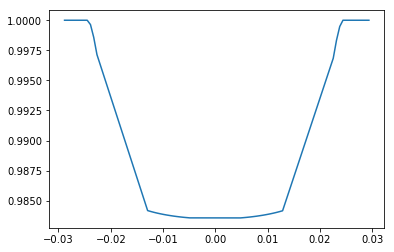

In [10]:
plt.plot(phase, mulimb01)
plt.show()